In [1]:
#from https://github.com/DeepLabCut/DeepLabCut/blob/6eefd0ccbc320daa76fb07c767209a37cc6fe40e/deeplabcut/utils/frameselectiontools.py#L1

In [3]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.util import img_as_ubyte
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Single video

In [118]:
vid = "vid000.mp4"
path = "/usr/users/agecker/datasets/ExplorationRoomZurna/hum/hum_2021-09-21_M1-2_cam19415032/"

cap = cv2.VideoCapture(path + vid)
numframes2pick = 5
step = 1
resizewidth=30
batchsize=100
max_iter=50
color=False
Index = None
allocated = False

nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
nx = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
ny = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
ratio = resizewidth * 1.0 / nx


if Index is None:
    Index = np.arange(0, nframes, step)
else:
    Index = np.array(Index)
    Index = Index[(Index >= 0) * (Index < nframes)]  # crop to range!
    


In [119]:
for counter, index in tqdm(enumerate(Index)):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    success, frame = cap.read()
    if frame is not None:
        image = img_as_ubyte(
        cv2.resize(
            frame,
            None,
            fx=ratio,
            fy=ratio,
            interpolation=cv2.INTER_NEAREST))  # color trafo not necessary; lack thereof improves speed.
        if not allocated:  #'DATA' not in locals(): #allocate memory in first pass
            DATA = np.empty(
                (nframes, np.shape(image)[0], np.shape(image)[1] * 3)
            )
            allocated = True
        DATA[counter, :, :] = np.hstack(
            [image[:, :, 0], image[:, :, 1], image[:, :, 2]]
        )

21000it [04:06, 85.20it/s] 


In [120]:
DATA.shape # (21000, 22, 90) 21000 images, 22 x 30 proportion after downsampling + 3 channels

(21000, 22, 90)

In [121]:
numframes2pick = 100
data = DATA - DATA.mean(axis=0)
data = data.reshape(nframes, -1)  # stacking
print(data.shape)
kmeans = MiniBatchKMeans(
    n_clusters=numframes2pick, tol=1e-3, batch_size=batchsize, max_iter=max_iter
)
kmeans.fit(data)

frames2pick = []
for clusterid in range(numframes2pick):  # pick one frame per cluster
    clusterids = np.where(clusterid == kmeans.labels_)[0]

    numimagesofcluster = len(clusterids)
    if numimagesofcluster > 0:
        frames2pick.append(
            Index[clusterids[np.random.randint(numimagesofcluster)]]
        )
# cap.release() >> still used in frame_extraction!
print(list(np.array(frames2pick)))

(21000, 1980)
[16540, 7969, 4773, 3013, 7053, 5760, 584, 17651, 5595, 5901, 9906, 20484, 6324, 6702, 19689, 3560, 8381, 5079, 9625, 9197, 8458, 6248, 19867, 8942, 9751, 8754, 70, 8294, 19152, 19448, 2648, 9276, 8410, 8528, 6993, 3796, 4193, 19382, 8607, 6948, 4318, 9714, 3336, 2943, 8661, 7669, 8220, 3151, 2562, 13489, 6292, 19227, 9412, 3604, 6660, 7106, 6937, 3496, 4590, 3035, 6192, 5971, 5682, 7915, 6064, 19548, 6431, 5450, 20736, 13288, 3907, 6559, 440, 19804, 20690, 20966, 4067, 20934, 14377, 8097, 5359, 3952, 17183, 9012, 6632, 20290, 5020, 4365, 581, 9516, 7893, 7388, 16619, 9426, 3848, 13512, 19769, 2967, 20168, 12042]


In [218]:
#pca = PCA(2)
#df = pca.fit_transform(data)

tsne = TSNE(2)
df = tsne.fit_transform(data)

label = kmeans.fit_predict(data)
u_labels = np.unique(label)
 

In [ ]:
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i, s = 1, alpha = 0.2)
plt.show()

In [217]:
print(label.shape)
unique, counts = np.unique(label, return_counts=True)

df = pd.DataFrame({"counts": counts, "unique": unique})
df.sort_values("counts", ascending = False).head()

(21000,)


,counts,unique
47,2534,47
87,1868,87
89,1679,89
76,1345,76
84,927,84


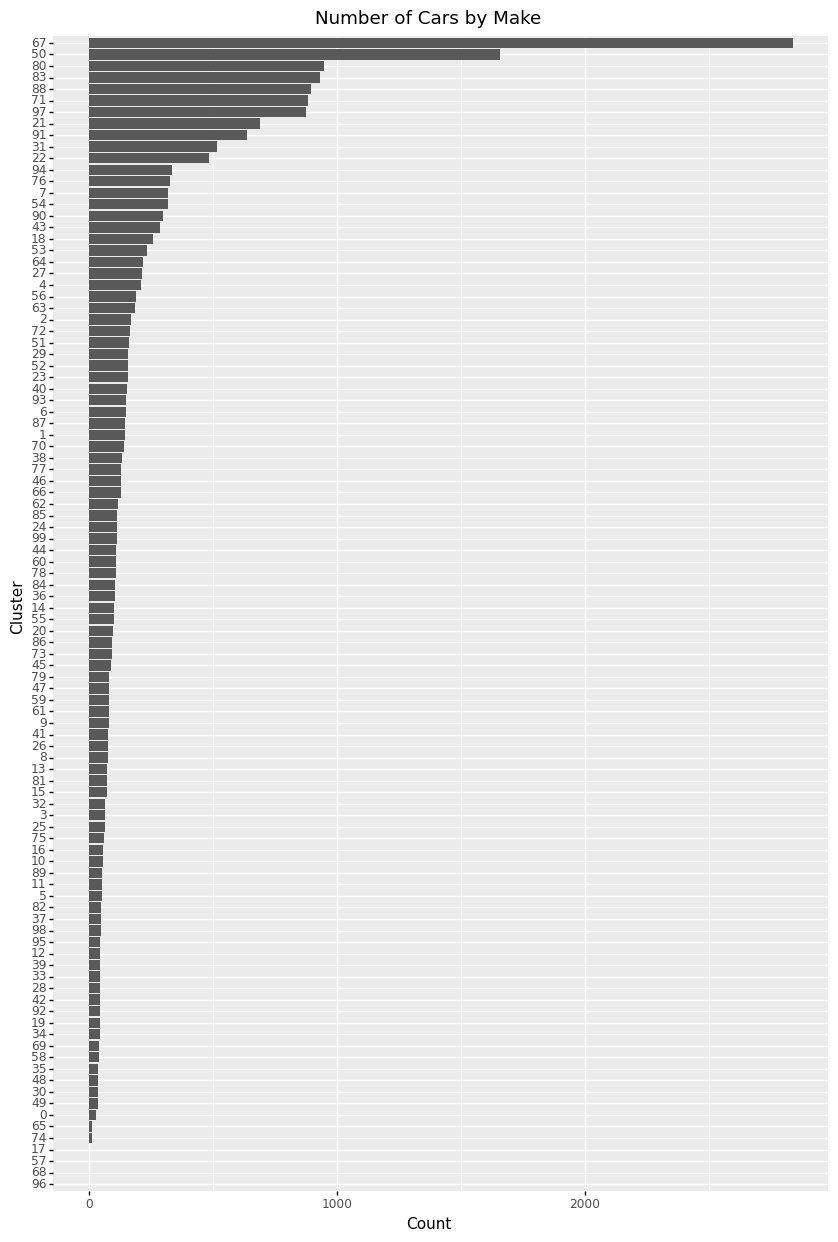

<ggplot: (8790349559592)>

In [210]:
from plotnine import *

cluster_list = df.sort_values("counts")['unique'].tolist()

category = pd.Categorical(df['unique'], categories=manufacturer_list)

# assign to a new column in the DataFrame
df = df.assign(cluster_ord = category)


plotnine.options.figure_size = (10, 15)
(ggplot(df)
 + aes(x='cluster_ord', y ="counts")
 + geom_col(size=20)
 + coord_flip()
 + labs(y='Count', x='Cluster', title='Number of frames per sample')
)

#### Show one cluster

57


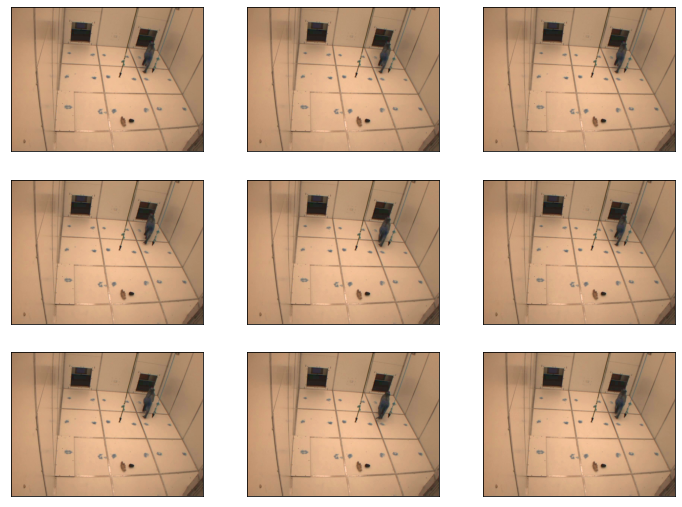

In [215]:
cluster = 10

ids = np.where(label == cluster)[0]
print(len(ids))
frames = ids[np.random.randint(0, len(ids), 9)]

fig, axs = plt.subplots(3, 3, figsize = (12,9))

for i, index in enumerate(list(np.array(frames))):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    success, frame = cap.read()
    axs[i//3, i%3].imshow(frame)
    axs[i//3, i%3].get_xaxis().set_visible(False)
    axs[i//3, i%3].get_yaxis().set_visible(False)

#### Show one representative from each cluster

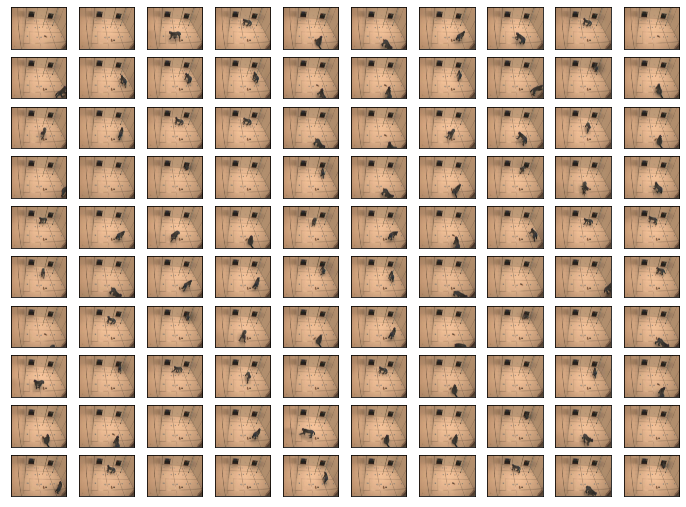

In [116]:
fig, axs = plt.subplots(10,10, figsize = (12,9))

for i, index in enumerate(list(np.array(frames2pick))):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    success, frame = cap.read()
    axs[i//10, i%10].imshow(frame)
    axs[i//10, i%10].get_xaxis().set_visible(False)
    axs[i//10, i%10].get_yaxis().set_visible(False)

## Multiple videos

In [4]:
# vids = ["Train"+str(i)+"_far" for i in range(1,4)] + ["Train"+str(i)+"_close" for i in range(4,11)]
from pathlib import Path
output_path = Path('/media/hdd2/matthias/datasets/lemur_box/validation/raw_frames/')
# p = Path('/media/hdd2/matthias/monkey_vids/')
# ps = []
# for ape in ['luk', 'hum', 'ken']:
#     ps = ps + [x for x in (p / ape).glob('*.mp4')]

p = Path('/media/hdd2/matthias/sfb1528_storage/Z01/PlaygroundSessions4ActionClassification/')
ps = [x for x in p.glob('*.mp4')]
# print(ps)

# path = "/usr/users/vogg/Labelling/Lemurs/"

for _, vid in tqdm(enumerate(ps)):
    # print(f"start on {vid}")

    cap = cv2.VideoCapture(str(vid))
    numframes2pick = 30
    step = 35 # 2 frames per second (70fps videos)
    resizewidth=30
    batchsize=100
    max_iter=50
    color=False
    Index = None
    allocated = False

    nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # print(f"gonna select from {nframes//step} frames")
    nx = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    ny = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    ratio = resizewidth * 1.0 / nx


    if Index is None:
        Index = np.arange(0, nframes, step)
    else:
        Index = np.array(Index)
        Index = Index[(Index >= 0) * (Index < nframes)]  # crop to range!

    nframesUsed = len(Index)

    # print("gonna read those frames")
    for counter, index in tqdm(enumerate(Index)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        success, frame = cap.read()
        if frame is not None:
            image = img_as_ubyte(
            cv2.resize(
                frame,
                None,
                fx=ratio,
                fy=ratio,
                interpolation=cv2.INTER_NEAREST))  # color trafo not necessary; lack thereof improves speed.
            if not allocated:  #'DATA' not in locals(): #allocate memory in first pass
                DATA = np.empty(
                    (nframesUsed, np.shape(image)[0], np.shape(image)[1] * 3)
                )
                allocated = True
            DATA[counter, :, :] = np.hstack(
                [image[:, :, 0], image[:, :, 1], image[:, :, 2]]
            )


    # print("gonna get those clusters")
    data = DATA - DATA.mean(axis=0)
    data = data.reshape(nframesUsed, -1)  # stacking
    # print(data.shape)
    kmeans = MiniBatchKMeans(
        n_clusters=numframes2pick, tol=1e-3, batch_size=batchsize, max_iter=max_iter
    )
    kmeans.fit(data)

    frames2pick = []
    # print("gonna pick those frames")
    for clusterid in range(numframes2pick):  # pick one frame per cluster
        clusterids = np.where(clusterid == kmeans.labels_)[0]
        print(clusterids)
        numimagesofcluster = len(clusterids)
        if numimagesofcluster > 0:
            frames2pick.append(
                Index[clusterids[np.random.randint(numimagesofcluster)]]
                # clusterids[np.random.randint(numimagesofcluster)]
            )
    # cap.release() >> still used in frame_extraction!
    # print(list(np.array(frames2pick)))
    
    # print("gonna save those frames")
    for i, index in enumerate(list(np.array(frames2pick))):
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        success, frame = cap.read()
        cv2.imwrite((str(output_path / vid.stem) + f"_{index}.png"), frame)#.with_suffix(".png"))
    # print("="*250)

2053it [01:03, 32.18it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619
 620 621 622 650 663 670 672 673 679 681 685 686 687 688 689 690 691 692
 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710
 711 712 713 714 715 716 717 718 719 720 721 722 724 725 726 729 731 733
 734 746 750 753 768 772 777 780 783 785 786 787 788 790 792 793 794 795
 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813
 814 815 816 819 820 825 834 835 836 837 838 840 841 843 845 846 847 849
 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867
 868 869 870 871 872 875 876 881 894 909 934 947 948 949 950 951 952 953
 961 962 963 964 965 966 967]
[1359 1361 1404 1406 1408 1523 1756 1757 1758 1759 1760 1761 1762 1763
 1764 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777
 1778 1779 1780 1850 1950 1951 1958 1959 1960 1961 1962 1963 1964 1965
 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979
 1980 1981 1982 1983 1984 198

2855it [01:28, 32.20it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340
 341 342 343 344 345 346 347 348 349 350 379 385 386 387 388 389 390 391
 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 521 522 523
 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541
 542 543]
[ 876  877  878  879  880  881  882  883  884  885  886  887  888  889
  890  891  892  893  894  895  896  897  898  911  912  913  918  947
  948  949  950  951  952  953  954  955  956  957  958  959  960  961
  966  967  968  969  970  971  972  973  974  975  976  977  978  979
  980  981  982  983  984  985  986  987  992  993  994  995  996  997
  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011
 1012 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028
 1029 1030 1031 1032 1033 1034 1035 1036 1037 1044 1045 1046 1047 1048
 1049 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1

2855it [01:24, 33.75it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 291  292  293  308  316  317  318  319  320  321  322  409  410  467
  468  544  545  546  547  548  549  615  616  619  622  623  694  748
  815  833  834  947  975  976  977  978  979  980  981  982  983  984
  985  986  987  988  989  990  991  992  993 1256 1257 1258 1259 1260
 1261 1262 1263 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273 1274
 1275 1276 1277 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1288
 1289 1290 1291 1292 1293 1294 1295 1296 1297 1298 1299 1300 1301 1302
 1303 1304 1305 1306 1307 1308 1309 1310 1311 1312 1313 1314 1315 1316
 1317 1318 1319 1320 1321 1322 1323 1324 1325 1326 1334 1335 1346 2322
 2676 2783 2794 2795 2796 2797 2798 2799 2800 2801 2802 2803 2804 2805
 2806 2807 2808 2809 2810 2811 2812 2813 2814 2815 2816 2817 2818 2819
 2820 2821 2822 2823 2824 2825 2836 2854]
[ 373 1468 1469 1470 1471 1472 1473 1474 1475 1476 1477 1478 1479 1480
 1481 1482 1483 1484 1485 1486 1487 1488 1489 1490 1491 1534 1535 1536
 1537 1538 1539 1540 1541 1542 1543

2855it [01:25, 33.49it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 369 1400 1401 1402 1403 1405 1406 1407 1408 1409 1410 1411 1412 1413
 1414 1415 1416 1417 1418 1419 1420 1421 1422 1423 1424 1425 1426 1427
 1428 1429 1432 1448 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458
 1459 1460 1461 1462 1463 1464 1465 1466 1467 1468 1469 1470 1471 1481
 1482 1483 1484 1485 1486 1487 1488 1489 1490 1491 1492 1493 1494 1495
 1496 1497 1499 1509 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519
 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1538 1539 1541
 1542 1543 1544 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555
 1556 1557 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575 1887
 1920 2789 2790]
[ 292  293  294  295  296  297  298  299  300  301  302  303  304  305
  307  319  322  323  324  325  326  327  328  329  330  331  332  333
  334  335  336  337  338  343  344  345  346  349  350  877  878  912
  913  914  915  916  917  918  976  977  978  979  980  981  982  983
  984  985  986  987  988  989  990  991  992  993  994  995

2855it [01:27, 32.63it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 355  848  849  921  922 1229 1230 1231 1232 1233 1234 1235 1601 1602
 1603 1604 1717 1718 1722 1723 1724 1725 1726 1727 1733 1837 1838 1839
 1840 1841 1842 1843 1844 1845 1846 1847 1848 1849 1850 1851 1852 1853
 1854 1855 1863 1864 1865 1876 1881 1882 1883 1887 1888 1889 1890 1891
 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905
 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919
 1920 1921 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2026 2226
 2227 2228 2229 2230 2231 2232 2233 2234 2235 2236 2237 2238 2239 2240
 2241 2242 2243 2244 2245 2246 2247 2248 2249 2250 2251 2252 2253 2254
 2255 2256 2257 2258 2259 2260 2261 2262 2263 2267 2268 2269 2270 2284
 2325 2326 2330 2331 2332 2333 2334 2335 2336 2337 2338 2339 2340 2341
 2342 2343 2344 2345 2346 2347 2348 2349 2350 2351 2352 2353 2354 2355
 2356 2357 2358 2359 2360 2361 2362 2363 2364 2365 2366 2367 2368 2369
 2370 2371 2372 2373 2374 2375 2376 2377 2378 2379 2380 2548 2549 2550
 2551 

2053it [01:04, 32.03it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1136 1137 1138 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149
 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163
 1164 1165 1166 1167 1168 1169 1170 1549]
[ 239  240 1523 1524 1525 1848 1849 1850 1851 1852]
[ 243  244  245  261  262  263  264  265  266  982  983  984 1067 1068
 1069 1132 1133 1953 1954]
[  84   85   86   87   88   89   90   91   92   93   94   95   96   97
   98   99  100  101  102  103  104  105  106  107  108  109  110  111
  112  113  114  115  116  117  118  119  120  121  122  123  124  125
  126  127  128  129  130  131  132  133  134  135  136  137  138  139
  140  141  142  143  144  145  146  147  148  149  150  151  152  153
  154  155  156  157  158  159  160  161  162  163  164  269  270  271
  272  273  274  275  276  277  278 1547]
[664 667 673 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693
 694 695 696 697 698 699 700 701 702 703 705 706 707 708 709 767 769 771
 772 773 774 775 776 777 778 779 780 781 782 783 784

2053it [01:02, 33.02it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 244  245 1254 1255 1256 1257 1260 1261 1283 1284 1285 1286 1287 1288
 1289 1290 1291 1292 1293 1294 1295 1296 1297 1298 1299 1300 1301 1302
 1303 1304 1305 1306 1307 1308 1309 1310 1311 1312 1313 1314 1315 1317
 1318 1319 1320 1321 1322 1323 1324 1325 1326 1327 1328 1329 1330 1331
 1332 1333 1334 1528 1529 1530 1531 1532]
[1487 1501 1565 1569 1591 1595 1606 1610 1636 1640 1647 1651 1677 1681
 1684 1685 1688 1689 1692 1717 1721 1722 1725 1726 1729 1730 1733 1734
 1738 1750 1754 1758 1760 1761 1762 1763 1764 1765 1766 1767 1768 1769
 1770 1771 1772 1773 1774 1775 1776 1777 1778 1779 1780 1781 1782 1783
 1852 1857 1861 1865 1869 1873 1877 1881 1885 1902 1906 1910 1914 1918
 1922 1926]
[165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 283 284 285 286
 287 288 289]
[

2053it [01:00, 33.84it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 285  286  287  288  550 1350 1411 1412 1413 1414 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1993 1994 1995]
[1134 1175 1179 1183 1187 1191 1354 1358 1362 1380 1384 1387 1388 1391
 1392 1395 1396 1399 1400 1404 1408 1465 1469 1473 1478 1482 1486 1490
 1494 1498 1502]
[1174 1176 1177 1178 1180 1182 1194 1195 1196 1198 1200 1202 1351 1352
 1353 1355 1356 1357 1359 1360 1361 1363 1364 1365 1366 1367 1368 1369
 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379 1381 1382 1383 1385
 1386 1389 1390 1393 1394 1398 1402 1405 1406 1407 1409 1491 1493 1495
 1497 1499 1501 1503 1505 1553 1554 1555 1556 1557 1558 1559 1560 1562
 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575 1576
 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586 1587 1588 1589 1590
 1591 1592 1593 1594 1595 1596 1597 1598 1599 1600 1601 1602 1603 1604
 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617 1618
 1619 16

2053it [01:01, 33.60it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379
 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548]
[204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 239 240 241 242 243]
[1489 1493 1498 1499 1502 1503 1506 1507 1510 1514 1518 1522 1556 1560
 1564 1567 1568 1571 1572 1575 1576 1580 1584 1585 1588 1589 1592 1593
 1596 1597 1600 1601 1604 1608 1612 1616 1630 1634 1637 1638 1641 1642
 1645 1646 1649 1650 1653 1654 1657 1658 1662 1666 1670 1671 1674 1675
 1678 1679 1682 1683 1686 1687 1690 1691 1694 1695 1698 1699 1702 1703
 1707 1711 1715 1719 1723 1724 1727 1728 1731 1732 1735 1736 1739 1740
 174

2053it [01:03, 32.24it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1137 1138 1205 1206 1207 1208 1209 1210 1211 1212 1213 1233 1334 1335
 1336 1337 1338 1339 1340 1341 1342 1343 1344 1551]
[605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622
 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640
 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658
 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676
 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694
 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712
 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730
 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748
 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766
 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784
 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802
 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820
 

1804it [00:56, 31.80it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1360 1361 1362 1363 1364 1365 1366 1367 1368 1369 1370 1371 1372 1373]
[ 167  168  170  171  172  174  175  176  178  179  180  181  182  183
  184  186  187  188  190  191  192  194  195  196  198  199  200  202
  203  204  206  207  208  209  210  211  212  213  214  215  222  731
  733  734  735  736  737  738  739  740  741  742  743  744  745  746
  747  748  749  750  751  752  753  754  755  756  757  758  759  760
  761  762  763  764  765  766  767  768  769  770  771  772  773  774
  775  776  777  778  779  780  781  782  783  784  785  786  787  788
  789  790  791  792  793  794  795  796  797  798  799  800  801  802
  803  804  805  806  807  808  809  810  811  812  813  814  815  816
  817  818  819  820  821  822  823  824  825  826  827  828  829  830
  831  832  833  834  835  836  837  838  839  840  841  842  843  844
  845  846  847  848  849  850  851  852  853  854  855  856  857  858
  859  860  861  862  863  864  865  866  867  868  869  870  871  872
  873

1804it [00:54, 33.12it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 226  227  228  229  230  231  232  233  234  235  236  237  238  239
  240  241  242  243  244  245  246  247  248  249  250  251  252  253
  254  255  256  265  266  267  268  269  270  271  272  273  274  275
  276  277  278  279  280  281  282  283  284  285  286  292  293  294
  295  296  297  298  299  300  301  302  303  304  305  306  307  308
  309  310  311  312  313  321  322  323  324  325  326  327  328  329
  330  331  332  333  334  335  336  337  338  339  340  341  342  343
  344  345  353  354  355  356  357  358  359  360  361  362  363  364
  365  366  367  368  369  370  371  372  373  374  375  376  377  378
  379  380  381  382  383  384  385  386  388  396  397  398  399  400
  401  402  403  404  405  406  407  408  409  410  411  412  413  414
  415  416  417  418  425  427  428  429  430  431  432  433  434  435
  436  437  438  439  440  441  442  443  444  445  446  447  448  449
  450  451  456  457  458  459  460  461  462  463  464  465  466  467
  468 

1804it [00:53, 33.73it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 219  220  221  222  223  225  226  938  939  969  970  971  972  973
  974  975  976  977  978  979  980  981  982  983 1352 1353 1354 1355
 1761]
[ 84  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 129 130 131 132 133 134 135 136 137 138
 139 140 141 143 144 145 160 161 162 163 164 166 167 731]
[215 216 217 218 737 738 739 740 741 742 743 744 745 746 747 748 749 760
 761 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779
 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 837 838 839
 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857
 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875
 876 877 878 887 889 890 891 892 893 894 895 896 897 898 899 900 901 902
 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920
 921 922 923 924 925 926 927 935]
[1569 1570 1571 1572 1573 1574 1579 1583 1586 1587 1588 1589 1590 1591
 1592 1593 1594 1595 1596 1597 

1804it [00:53, 33.55it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 226  227  253  254  256  257  258  284  287  311  313  314  315  343
  344  345  347  383  385  386  387  389  417  418  419  420  449  450
  451  452  479  480  481  482  506  507  508  509  538  539  540  541
  542  596  597  598  599  600  601  602  603  604  605  679  680  681
  682  683  684  685  686  687  688  689  690  691  692  693  694  695
  696  697  698  699  700  701  702  703  704  705  706  707  708  709
  710  711  712  713  714  715  716  717  718  719  720  725  726  727
  728  938  939  965  966  967  968  988  989  990  991 1017 1018 1019
 1020 1021 1041 1042 1043 1062 1063 1064 1065 1082 1083 1084 1085 1105
 1106 1107 1108 1109 1129 1130 1131 1132 1157 1158 1159 1160 1161 1181
 1182 1183 1184 1202 1203 1204 1205 1225 1226 1227 1245 1246 1247 1248
 1268 1269 1270 1271 1273 1295 1296 1297 1298 1299 1300 1332 1333 1334
 1335 1336 1547]
[187 198 217 219 220 221 222 223 224 225 232 236 240 244 251 255 259 263
 274 278 282 293 297 312 316]
[1570 1571 1572 1573 1574 15

1804it [00:55, 32.25it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 263  265  266  267  268  275  291  292  293  294  298  320  321  322
  323  324  327  352  353  354  355  356  357  359  363  396  397  398
  399  400  401  425  426  427  428  429  456  457  458  459  461  486
  487  488  489  514  515  516  517  518  548  549  550  551  552  553
  556  558 1508 1509 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519
 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533
 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544 1545 1546 1547
 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559]
[222 223 224 225 226]
[ 984  985  986  987  988  989  990  991  992  993  994  995  996  997
  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011
 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025
 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039
 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053
 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 106

1945it [01:00, 32.01it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1345 1346 1347 1348 1349 1350 1351 1352 1353 1354 1355 1356 1362 1363
 1364 1365 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377
 1378 1379 1380 1381 1386 1387 1388 1389 1390 1391 1392 1393 1394 1395
 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406 1413 1414 1415
 1416 1417 1418 1419 1420 1421 1422 1423 1424 1425 1426 1427 1428 1429
 1430 1431 1432 1433 1434 1435 1436 1437 1438 1439 1440 1441 1449 1450
 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462 1463 1464
 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476 1477 1478
 1479 1480 1481 1482 1491 1492 1493 1494 1495 1496 1497 1498 1499 1500
 1501 1502 1503 1504 1505 1506 1507 1508 1509 1510 1511 1512 1513 1514
 1515 1516 1517 1518 1519 1520 1529 1530 1531 1532 1533 1534 1535 1536
 1537 1538 1539 1540 1541 1542 1543 1544 1545 1546 1547 1548 1549 1550
 1551 1552 1553 1554 1555 1556 1557 1558 1559 1560 1561 1562 1563 1564
 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575 1585 1586 1587
 1588 

1945it [00:58, 32.97it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 171  172  173  174  175  176  177  178  179  180  181  182  183  184
  185  186  187  188  189  190  191  192  193  194  195  196  197  198
  199  200  201  202  203  204  205  206  207  208  209  210  211  212
  213  214  215  216  217  218  219  220  221  222  223  224  225  226
  227  228  229  230  231  232  233  234  235  236  237  238  239  240
  241  242  243  244  245  246  247  248  249  250  251  252  253  254
  255  256  257  258  259  260  261  262  263  264  265  266  267  268
  269  270  271  659  660  661  832  987  988 1666 1667 1668 1669 1670
 1671 1672 1673 1674 1675 1676 1677]
[1342 1343 1344 1345 1346 1347 1348 1349 1350 1351 1352 1353 1354 1355
 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365 1366 1367 1368 1369
 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379 1380 1381 1382 1383
 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393 1394 1395 1396 1397
 1398 1399 1400 1401 1402 1403 1404 1405 1406 1407 1408 1409 1410 1411
 1412 1413 1414 1415 1416 1417 1418 1419

1945it [00:57, 33.66it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[339 340 341 343 344 345 347 348 349 351 352 353 355 356 364 365 368 369
 372 373 376 377 380 381 384 385 388 389 390 392 393 394 396 400 401 402
 404 405 406 408 409 410 412 413 414 416 417 418 421 425 426 428 429 430
 432 433 434 437 438 441 442 445 446 449 450 453 454 455 457 458 459 461
 462 463 465 466 467 469 470 471 473 474 475 477 478 481 482 483 485 486
 487 489 490 491 492 493 494 495 496 497 498 499 500 502 506 507 508 509
 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527
 530 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550
 551 552 558]
[1688 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700 1701
 1702 1703 1704 1705 1706 1707 1708 1709 1710 1711 1712 1713 1714 1715
 1716 1717 1718 1719 1720 1721 1722 1723 1724 1725 1726 1727 1728 1729
 1730 1731 1732 1733 1734 1735 1736 1737 1738 1739 1740 1741 1742 1743
 1744 1745 1746 1747 1748 1749 1750 1793 1794 1795 1796 1797 1798 1799
 1800 1801 1802 1803 1804 1805 1806 1807 1808 1

1945it [00:58, 33.32it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[  3   7  11  12 304 307 308 320 332 336 340 344 348 352 370 374 375 378
 379 382 393 397 401 405 409 412 413 416 417 420 424 425 428 429 432 433
 436 437 440 441 444 445 448 449 452 470 474 478 482 486 490 494 498 502
 506 510 514 518 522 526 548 551 552 555 556 669]
[354 356 358 360 362 366 383 385 386 387 389 390 394 398 402 404 406 408
 447 451 453 455 456 459 460 462 463 464 466 467 468 471 475 479 483 487
 489 491 493 495 497 499 501 503 505 507 509 511 513 517 521 525 528 529
 530 532 533 534 536 537 538 540 541 542 543 544 545 547 549 553]
[ 15  16  19  20  23  24  27  28  31  32  35  36  39  40  43  44  47  48
  51  52  55  56  59  60  63  64  67  71  75  79  83  87  91  95  99 103
 107 111 115 119 123 127 131 133 135 137 139 141]
[559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576
 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594
 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612
 613 614 615 616 617 618 619 62

1945it [01:00, 32.28it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1262 1263 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275
 1276 1277 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289
 1290 1291 1292 1293 1294 1295 1296 1297 1298 1299 1300 1339 1665 1779]
[ 326  327  328  330  331  332  335  336  339  340  341  343  344  345
  348  349  352  353  356  357  360  361  364  365  368  369  372  373
  376  377  380  381  384  385  388  389  392  393  396  397  400  401
  402  404  405  406  408  409  410  412  413  414  417  418  421  422
  425  426  429  430  433  434  437  438  441  442  445  446  449  450
  453  454  457  458  461  462  465  466  469  470  471  473  474  475
  477  478  479  481  482  483  485  486  487  489  490  491  494  495
  498  499  502  503  506  507  510  511  514  515  518  519  522  523
  526  527  530  531  534  535  538  539  540  542  543  544  546  547
  548  551 1685 1686]
[ 941  942  943  944  945  946  947  948  949  950  951 1301 1302 1303
 1304 1305 1306 1307 1308 1309 1310 1311 1312 1313 131

1504it [00:47, 31.80it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626]
[ 243  247  251  324  328  336  337  341  345  349  353  357  361  365
  369  373  377  381  385  389  393  397  401  402  405  406  410  414
  418  422  426  434  438  442  446  450  458  462  466  467  470  471
  479  481  483  485  487  489  493  495  532  536  540  542  544  548
  550  552  554  556  558  560  562  564  570  574  578  585  589  593
  595  597  601  603  604  605  606  607  608  609 1181 1182 1183 1184
 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195 1196]
[  64 1402 1403 1404 1407 1408 1409 1410 1411 1412 1419 1420 1421 1422
 1423 1434 1435 1436 1437 1438 1439 1440 1446 1475 1476 1477 1478 1479]
[147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 177 178 179 180 184 185 186 187 188]
[ 677  683  684  685  686  687  688  689  690  691  692  693  694  698
  699  700  701  702  703  704  705  706  707  708  712  713  714  715
  716  717  71

1504it [00:45, 32.74it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[294 412 431 473 484 488 533 534 537 538 542 582 590 599 607 611 667 668
 669 671 672 673 675 676 680 688]
[1426 1427 1428 1429 1430 1434 1451 1452 1453 1454 1455 1456 1457 1458
 1459 1460 1461 1462 1463 1464 1465 1466 1467 1468 1470 1471 1477 1480
 1487 1488 1492 1493 1494 1495 1497 1498 1499 1500 1503]
[1180]
[1405 1411 1412 1413 1414 1415 1416 1417 1418 1419 1423 1424 1425 1431
 1432 1433 1437 1438 1439 1440 1441 1442 1443 1444 1445 1450 1469 1474
 1475 1476 1478 1479 1481 1482 1486 1489 1490 1491 1501 1502]
[ 86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
[ 647  648  649  650  651  652  653  654  655  656  657  658  659  660
  661  662  663  664 1383 1384 1385]
[298 318 334 338 358 359 362 379 399 415 416 436 456 477 497 513 529 550
 570]
[244 248 260 313 317]
[  63   64   67   68   69   70   71   72   73   74 1406 1407]
[256 264 301 302 306 309 310 314 321 322 326 330 342 346 350 354 355 363
 366

1504it [00:44, 33.47it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 683  684  687  688  691  692  695  696  699  700  703  704  711  712
  716  720  724  727  728  732  736  737  740  741  744  745  748  749
  752  753  755  760  761  764  765  768  769  776  777  780  781  784
  785  789  792  793  797  801  808  809  813  817  821  822  829  830
  833  837  838  841  845  846  849  850  853  854  859  861  862  865
  866  869  873  874  878  882  890  894  897  901  902  906  910  911
  914  915  918  922  925  931  934  938  939  943  944  950  954  957
  958  963  966  967  970  971  975  979  980  984  987  988  991  999
 1003 1007 1008 1011 1012 1015 1016 1019 1020 1024 1027 1028 1029 1030
 1032 1036 1037 1039 1040 1041 1043 1044 1045 1046 1049 1050 1051 1052
 1053 1055 1056 1058 1059 1062 1063 1064 1065 1066 1067 1068 1070 1071
 1074 1075 1076 1077 1079 1080 1085 1086 1088 1089 1091 1093 1094 1097
 1099 1100 1101 1105 1106 1109 1113 1115 1116 1119 1120 1123 1124 1125
 1127 1128 1133 1136 1137 1138 1140 1141 1142 1143 1144 1145 1146 1147
 1150 

1504it [00:45, 33.25it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
[ 320  348  352  409  410  413  421  425  429  431  433  441  445  486
  488  528  557  561  681  689  693  695  697  698  702  703  706  707
  710  711  718  722  724  726  734  736  738  742  744  748  750  752
  754  756  758  760  762  767  768  771  772  775  776  781  783  784
  785  787  788  789  793  801  805  809  821  825  828  829  836  837
  840  841  844  845  848  852  853  854  857  858  861  862  866  869
  870  873  874  881  882  885  886  889  893  894  897  898  901  902
  906  909  910  913  914  921  922  923  926  927  930  931  934  935
  938  939  942  943  950  951  954  955  958  959  963  966  967  970
  971  978  979  982  983  986  990  991  992  994  995  996  999 1000
 1003 1004 1007 1008 1011 1012 1016 1019 1020 1023 1024 1029 1031 1032
 1033 1035 1036 1037 1043 1044 1045 1047 1048 1049 1051 1055 1056 1057
 1060 1061 1064 1068 1069 1072 1073 1076 1080 1081 1082 1084 1085 1086
 1090 1092 1093 10

1504it [00:46, 32.12it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1233]
[ 693  694  695  708  709  722  723  724  738  739  740  756  757  758
  772  773  786  787  788  805  806  824  825  826  842  843  844  857
  858  859  870  871  872  884  885  897  898  899  912  913  925  926
  927  940  941  954  955  956  968  969  981  982  995  996 1008 1009
 1010 1021 1022 1034 1035 1047 1048 1059 1060 1061 1071 1072 1083 1084
 1094 1095 1106 1107 1119 1120 1121 1133 1134 1135 1146 1147 1148 1161
 1162 1224 1225 1236 1237 1248 1249 1250 1251 1263 1264 1265 1279 1280
 1281 1294 1295 1296 1308 1309 1319 1320 1331 1332 1342 1343 1344 1354
 1355 1356 1366 1367 1368]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 64 65 66 78 79 80 81 82 83 84]
[ 682  686  690  698  699  702  703  706  707  710  711  714  715  718
  719  726  727  730  731  735  743  747  751  752  755  759  760  763
  764  767  768  771  775  776  779 

1421it [00:43, 32.30it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 541  549  571  575  579  587  750  754  766  770  774  778  782  786
  924  928  941  944  945  948  949  952  953  956  957  960  961  964
  965  968  969  981  985  989  993  997  998 1001 1002 1005 1006 1009
 1010 1013 1014 1038 1042 1046 1050 1054 1058 1059 1062 1063 1066 1067
 1070 1071 1074 1075 1078 1079 1082 1083 1095 1099 1103 1107 1111 1115
 1116 1119 1120 1123 1124 1127 1128 1131 1132 1135 1136 1139 1140 1143
 1144 1147 1148 1151 1152 1156 1160 1164 1168 1172 1176 1180 1184 1185
 1192 1193 1196 1197 1200 1201 1204 1205 1209 1213 1217 1229 1233 1237
 1241 1245 1249 1250 1253 1254 1257 1258 1261 1262 1265 1266 1270 1274
 1278 1282 1286 1290 1294 1298 1302 1306 1310 1314 1318 1322 1335 1339
 1343 1347 1351 1355 1359 1363 1367 1371 1375 1379 1380 1383 1384 1388
 1391 1392 1400 1404 1408 1412 1416 1420]
[ 98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118]
[237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 

1421it [00:42, 33.38it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1152 1153 1154 1156 1157 1160 1161 1162 1164 1165 1166 1168 1169 1170
 1172 1173 1174 1176 1177 1182 1185 1193 1194 1196 1197 1198 1200 1201
 1202 1204 1205 1206 1208 1209 1210 1212 1213 1214 1217 1226 1229 1230
 1231 1233 1234 1235 1237 1238 1239 1241 1242 1243 1245 1246 1247 1249
 1250 1251 1253 1254 1255 1257 1258 1259 1261 1262 1263 1265 1266 1267
 1269 1270 1271 1273 1274 1275 1276 1278 1279 1280 1282 1283 1286 1287
 1288 1290 1291 1292 1294 1295 1296 1298 1299 1300 1302 1303 1304 1306
 1307 1308 1310 1311 1312 1314 1315 1316 1318 1319 1320 1331 1334 1335
 1336 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1351 1352
 1353 1355 1356 1357 1359 1360 1361 1363 1364 1365 1367 1368 1369 1371
 1372 1373 1375 1376 1377 1379 1380 1381 1382 1383 1384 1385]
[380 381 382 384 385 396 398 400 402 403 406 407 410 411 414 415 418 419
 422 423 426 427 430 431 434 435 438 439 442 443 446 447 451 455 459 460
 463 464 467 468 471 472 475 476 479 480 483 484 487 488 491 492 495 496
 499 500 

1421it [00:42, 33.44it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 346  375  379  785  789  925  929  932  933  940  941  942  943  944
  945  946  947  948  949  950  951  952  953  954  955  956  957  958
  959  960  961  962  963  964  965  966  967  968  969  970  971  972
  973  974  980  981  982  983  984  985  986  987  988  989  990  992
  994  997 1000 1001 1002 1016 1017 1019 1020 1021 1022 1023 1037 1038
 1039 1040 1042 1057 1058 1059 1066 1069 1084 1085 1087 1088 1097 1098
 1099 1100 1101 1148 1151 1169 1187 1188 1194 1195 1221 1230 1231 1232
 1235 1236 1318 1325 1326 1334 1335 1336 1337 1338 1339]
[344 422 548 552 556 560 584 596 600 604 608 612 616 620 624 628 632 636
 637 640 641 644 645 648 649 652 653 656 657 660 661 664 668 672 676 680
 684 688 692 696 700 704 708 712 716 720 728 732 736 740 744 748 752 756
 760]
[345 349 353 357 361 365 369]
[282 283 284 285]
[159 162 163 164 165 166 167 168 169 170 171 172]
[342 343 380 383 384 387 388 391 392 395 396 399 400 403 404 407 408 411
 412 415 416 419 420 423 424 426 427 428 430 431 4

1421it [00:42, 33.44it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[408 420 428 432 436 440 444 448 482 490 494 522 523 526 530 534 535 538
 539 542 543 546 547 566 567 579 583 584 587 588 591 592 595 596 599 600
 607 608 611 612 615 616 619 620 623 624 640 641 644 645 648 649 652 653
 692 693 694 697 698 701 702 705 706 709 710 713 714 717 718 721 722 725
 726 730 733 734 737 738 741 742 745 746 749 750 753 754 757 758 762 766
 770 778 782 783]
[138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172]
[789 792 793 809 813 817 818 821 822 825 826 829 830 833 834 837 838 842
 845 846 849 850 853 854 857 858 861 862 866 870 871 874 875 878 879 882
 883 886 887 890 891 894 895 898 899 902 903 906 907 910 911 914 915 918
 919 926]
[ 371  938  940 1033 1034 1036 1038 1040 1093 1094 1095 1096 1097 1098
 1099 1101 1105 1192 1193 1194 1195 1196 1197 1225 1226 1227 1228 1229
 1230 1231 1232 1233 1234 1235 1236 1239 1330 1331 1332 1333 1334 1335
 1336 1337 1338 1339 1340]
[ 785

1421it [00:44, 32.18it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[331 333 334 335 336 337 338 339 340 341 342 343 344 384 388 392 396 400
 404 408 412 416 534 538 539]
[1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070
 1071 1072 1083 1111 1112 1113 1114 1115 1116 1388]
[1152 1153 1155 1156 1157 1198 1199 1200 1201 1202 1203 1204 1205 1206
 1207 1208 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220
 1221 1222 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234
 1235 1237 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249
 1250 1251 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263
 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276 1278
 1279 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292
 1293 1294 1295 1296 1297 1298 1299 1300 1302 1303 1304 1305 1306 1307
 1308 1309 1310 1311 1312 1313 1314 1320 1349 1350 1351 1352 1353 1354
 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365 1366 1367 1368
 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379 1380 138

1865it [00:57, 32.33it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[  2   3   6   7  12  16  20  24  28  32 592 593 594 595 596 597 598 599
 600 601 748 749 750]
[ 559 1036 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1057
 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070 1071
 1072 1073 1075 1077 1078 1080 1348 1351 1352 1353 1354 1355 1356 1357]
[ 711  911  912  913  914  915  916  917  918  919  920  921  922  923
  924  925  926  927  928  929  930  931  932  933  934  935  936  937
  938  939  940  941  942  943  944  945  946  947  948  949  950  951
  952  953  954  955  956  957  958  959  960  961 1100 1101 1102 1103
 1104 1105 1106 1107 1108 1109 1110 1111 1112 1113 1114 1115 1116 1117
 1398 1399 1400 1401 1833 1834 1835 1836 1837 1838 1839 1840 1841 1842
 1843 1844 1845 1846 1847 1848 1849 1850 1851 1852 1853 1854 1855 1856
 1857 1858 1859 1860 1861 1862 1863 1864]
[ 169  170  564  588  589  632  633  837  838 1084 1370 1371 1479 1480
 1699 1700 1701 1702 1703 1704 1705 1706 1707 1708 1709 1710 1711 1712
 1713 1714

1865it [00:57, 32.50it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 169  170  564  586  587  588  632  838 1084 1085 1370 1479 1480 1699
 1700 1817]
[  37  133  134  135  136  137  138  139  140  141  158  173  174  175
  176  177  178  179  180  190  191  192  193  194  195  196  197  198
  199  200  201  202  203  204  498  499  503  507  511  514  534  535
  536  537  538  539  540  541  542  543  544  545  546  547  548  549
  550  551  552  638  639  640  641  642  643  644  645  646  647  648
  649  651  652  714  715  716  717  718  719  773 1088 1089 1090 1091
 1092 1093 1094 1095 1109 1110 1111 1112 1113 1114 1115 1116 1117 1118
 1119 1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132
 1133 1134 1135 1136 1137 1138 1139 1140 1141 1142 1143 1144 1145 1146
 1147 1148 1149 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160
 1161 1162 1163 1164 1234 1235 1236 1237 1238 1239 1240 1241 1242 1243
 1244 1245 1246 1247 1248 1249 1250 1251 1252 1253 1254 1255 1256 1257
 1258 1259 1374 1375 1400 1401 1402 1403 1404 1405 1406 1407 1408

1865it [00:56, 32.85it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[  39   40   41   42   43   44   45   46   47   48   49   50   51   52
   53   54   55   56   57   58   59   60   61   62   63   64   65   66
   67   68   69   70   71   72   73   74   75   76   77   78   79   80
   81   82   83   84   85   86   87   88   89   90   91   92   93   94
   95   96   97   98   99  100  101  102  103  104  105  106  107  108
  109  110  111  112  113  114  115  116  117  118  119  120  121  122
  123  124  125  126  162  589  782  783  784  785  790  791  792  793
 1005 1347 1477]
[129 130 131 132 133 134 135 136 137 138 139 158 171 172 173 174 175 176
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299 300 301 302 303 304 305 306 307 308 309

1865it [00:56, 32.94it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 171  172  553  554  555  556  557  558  560 1351 1352 1353 1354 1355
 1356 1361 1362 1363 1364 1365 1366 1367 1368]
[ 536  537  538  566  567  571  573  575  583  584  635  636  637  638
  639  640  645  646  647  648  649  650  651  652  653  654  655  656
  657  658  659  660  661  662  663  664  665  666  667  668  669  670
  671  672  673  674  675  676  677  678  679  680  681  682  683  684
  714  715  716  717  840  841  842  843  845  885  886  887  888  889
  890  891  892  893  894  895  896  897  898  899  900  901  902  903
  904  905  906  907  908  909  910  911  912  913  914  915  916  917
  918  919  920  921  922  923  924  925  926  927  928  929  930  931
  932  933  934  935  963  964  965 1087 1088 1089 1090 1091 1092 1093
 1094 1095 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195 1196
 1197 1198 1199 1200 1201 1202 1203 1257 1258 1259 1260 1340 1341 1372
 1373 1374 1375 1376 1377 1379 1380 1381 1382 1383 1384 1385 1386 1387
 1388 1389 1390 1391 1416 1417

1865it [00:58, 32.11it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 843  844  845  846  847  848  849  850  851  852  853  854  855  856
  857  858  859  860  861  862  863  864  865  866  867  868  869  870
  871  872  873  874  875  876  877  878  879  880  881  882  883  884
  885 1375 1376 1377 1378 1379 1380 1381 1382 1383 1484 1485 1486 1487
 1488 1489 1490 1491 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501
 1502 1503 1504 1505 1506 1507 1508 1509 1510 1511 1512 1513 1514 1515
 1516 1517 1518 1519 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529
 1530 1531 1532 1533 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543
 1544 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557
 1558 1559 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571
 1572 1573 1574 1575 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585
 1586 1587 1588 1589 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599
 1600 1601 1602 1603 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613
 1614 1615 1616 1617 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627
 1628 

1741it [00:54, 32.17it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 477  478  479  482  483  484  485  486  487  488  489  490  491  492
  493  494  495  537  538  539  540  541  542  543  544  545  546  547
  548  549  550  569  769  770  771  776  777  778  779  807  808  809
  825  826  827  828  995  996  997  998 1003 1004 1005 1006 1007 1008
 1009 1010 1011 1012 1029 1030 1057 1058 1059 1073 1074 1075 1076 1077
 1127 1150 1151 1156 1188 1189 1190 1191 1192 1193 1221 1339 1340 1341
 1386 1387 1388 1416 1417 1418 1419 1420 1421 1422 1423 1424 1425 1426
 1427 1428 1429 1430 1431 1432 1433 1434 1435 1458 1459 1460 1461 1465
 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476 1477 1525 1526
 1527 1553 1571 1572 1573 1577 1605 1606 1607 1622 1623 1624 1625 1631
 1646 1647 1648 1649 1650 1672 1673 1674 1675 1676 1677 1678 1679 1685
 1686]
[  90   92   93   94   95   96   97   98   99  100  101  318  319  320
  321  322  323  324  326  327  328  330  331  332  333  334  335 1224
 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237 1238

1741it [00:53, 32.37it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 95  96  98 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319
 320 321 322 323 324 325 326 327 328 329 330 331 332]
[ 366  368  369  370  372  373  374  376  377  378  380  381  382  384
  385  386  388  389  390  392  393  396  397  400  401  404  405  408
  409  412  413  416  417  420  421  423  424  425  427  428  429  431
  432  433  435  436  437  439  440  441  443  444  445  447  448  449
  451  452  453  455  456  457  459  460  578  579  580  582  583  584
  585  586  587  588  589  590  591  592  593  594  595  596  597  598
  599  600  602  603  604  605  606  607  608  615  616  618  619  620
  621  622  623  624  626  627  628  629  630  631  632  634  635  636
  637  638  639  640  642  643  644  646  656  657  658  659  660  661
  662  663  664  665  666  667  668  669  670  671  672  673  674  675
  676  677  678  679  680  681  682  683  684  685  686  687  688  689
  690  691  692  693  694  695  696  697  698  699  700  701  702  703
  704  705  706  707 

1741it [00:53, 32.70it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 547  548  549  550  551  552  553  554 1008 1009 1010 1076 1077 1177
 1178 1179 1189 1400 1414 1429 1438 1439 1440 1441 1465 1466 1467 1468
 1469 1470 1471 1472 1473 1474 1475 1476 1570 1610 1611 1612 1613 1684
 1685]
[ 391  392  393  394  395  396  397  398  399  400  401  402  403  404
  405  406  407  408  409  410  411  412  413  414  415  416  417  418
  419  420  421  422  423  424  425  426  427  428  429  430  431  432
  433  434  435  436  437  438  439  440  441  442  443  444  445  446
  447  448  449  450  451  452  453  454  455  456  457  458  459  460
  461  462  463  464  465  466  467  468  469  470  471  472  473  474
  475  476  832  833  834  835  836  837  838  839  840  841  842  843
  844  845  846  847  848  849  850  851  852  853  854  855  856  857
  858  859  860  861  862  863  864  865  866  867  868  869  870  871
  872  873  874  875  876  877  878  879  880  881  882  883  884  885
  886  887  888  889  890  891  892  893  894  895  896  897  898  899

1741it [00:52, 33.25it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 569  570  571 1031 1032 1127 1128 1129 1221 1222 1223 1365 1366 1367
 1435 1436 1437 1505 1506 1553 1554 1555 1607 1608 1609]
[ 358  359  360  361  362  363  364  365  366  367  368  369  370  371
  372  373  374  375  376  377  378  379  380  381  382  383  384  385
  386  387  388  389  390  391  392  393  394  395  396  397  398  399
  400  401  402  403  404  405  406  407  408  409  410  411  412  413
  414  415  416  417  418  419  420  421  422  423  424  425  426  427
  428  429  430  431  432  433  434  435  436  437  438  439  440  441
  442  443  444  445  446  447  448  449  450  451  452  453  454  455
  456  457  458  459  460  461  462  463  464  465  466  467  468  469
  470  471  472  473  474  475  476  477  478  576  577  578  579  580
  581  582  583  584  585  586  587  588  589  590  591  592  593  594
  595  596  606  607  608  609  610  611  612  613  614  615  616  617
  618  619  620  621  622  623  624  625  626  627  628  629  630  631
  632  633  634  635

1741it [00:54, 32.03it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 583  584  585  586  587  588  589  590  591  592  593  594  595  596
  597  598  599  600  601  602  603  604  605  606  607  608  609  610
  611  612  613  614  615  616  617  618  619  620  621  622  623  624
  625  626  627  628  629  630  631  632  633  634  635  636  637  638
  639  640  641  642  643  644  645  646  647  648  649  650  651  652
  653  654  655  656  657  658  659  660  661  662  663  664  665  666
  667  668  669  670  671  672  673  674  675  676  677  678  679  680
  681  682  683  684  685  686  687  688  689  690  691  692  693  694
  695  696  697  698  699  700  701  702  703  704  705  706  707  708
  709  710  711  712  713  714  715  716  717  718  719  720  721  722
  723  724  725  726  727  728  729  730  731  732  733  734  735  736
  737  738  739  740  741  742  743  744  745  746  747  748  749  750
  751  752  753  754  755  756  757  758  759  760  761  762  763  764
 1042 1043]
[903]
[  90   96   97   98   99  100  101  104  105  108  109  11

1577it [00:40, 39.04it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[735 737 738 739 740 741 742 743 746 747 750 751 766 767 776 777 778 779
 780 783 784 786 787 788 790 791 792 794 795 807 808 811 812 819 820 824
 825 828 832]
[ 70  71  72 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136]
[ 32  33  34  35  47  48  49  50  51  52  53  54 139]
[ 61  62  63  65  67  68 672 675 676 677 678 679 680 681 682 696 697 698
 699 700 701 702 703 704 705 706 707 708 715 716 717 718 719 720 721 722
 723 724 725 726 727 728 744 745 752 753 754 755 756 757 758 759 760 761
 762 763 764 765 781 782 785 789 793 827 844 845 846 847]
[143 146 147 150 151 154 155 156 158 159 160 162 163 164 166 167 168 171
 172 175 176 179 180 183 184 187 188 191 192 193 195 196 197 200 201 204
 205 208 209 212 213 216 217 220 221 224 225 228 229]
[261 262 265 266 269 270 273 274 277 278 281 282 286 290 294 295 298 299
 302 303 306 307 310 311 314 315 318 319 322 323 327 331 335 339 343 347
 348 351 352 355 356 359 360 363 364 368 372 376 380 384 385 388 389 392
 393 39

1577it [00:47, 33.08it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 141  156  158  160  164  191  195  197  199  201  203  205  207  209
  213  671  922  923  924  939  940 1227 1228 1229 1367 1368 1369 1477
 1478 1573 1574 1575]
[   0   29   70  246  248  250  252  254  293  295  297  299  301  303
  334  336  338  340  342  344  348  379  381  383  385  387  389  391
  393  420  422  424  426  428  430  432  434  436  438  477  479  481
  483  485  487  510  512  514  516  518  520  522  524  526  528  530
  532  555  557  559  561  563  565  567  569  571  573  575  577  579
  600  602  604  606  608  610  612  614  616  618  620  622  624  626
  628  645  647  649  651  653  655  657  659  661  663  665  667  921
  927  928  929  930  931  932  933  935  936  941  942  943  944  945
  946  947  948  949  950  951  952  953  954  955  956  957  958 1218
 1219 1220 1221 1222 1223 1224 1225 1226 1249 1250 1251 1365 1366 1383
 1384 1385 1419 1420 1471 1475 1476 1571 1572]
[673 674 675 676 677 678 679 682 686 687 688 690 691 692 694 695 696 698
 702 7

1577it [00:47, 33.16it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[236 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 521 522 534 538 539 540 541 542 543 544 545 546 547 548 549 550 551
 552 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570
 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588
 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606
 607 608 609 610 611 612 613 614 615 616 617 618 619 620 632 635 636 637
 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 673
 674]
[ 138  237  238  239  240  241  242  243  244  482  483 1233 1373 1499]
[  55   56   57   69   70   73  119  136  137  245  246  481 1234 1374]
[479 480 520 523 524 525 526 527 528 529 530 531 532 533 535 536 537 553
 621 622 623 624 625 626 627 628 629 630 631 633 634]
[1241 1242 1243 1244 1245 1246 1247 1248 1255 1256 1257 1258 1259 1260
 1261 1262 1263 1264 1265 1266 1267 1268 1269 1278 1279 1280 1281 12

1577it [00:46, 33.59it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1289 1290 1292 1293 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303
 1304 1305 1306 1307 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317
 1318 1319 1320 1321 1322 1323 1324 1325 1326 1327 1328 1329 1330 1331
 1332 1333 1334 1335 1336 1337 1338 1339 1340 1341 1342 1423 1563 1564
 1565]
[674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691
 692 730 731 735 736 737 738 739 740 741 742 743 744 745 746 748 768 769
 770 771 772 773 774 775 776 777 778 779 794 795 801 803 804 805 833 839
 841 842 843 844 845]
[234 235 238 242 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285
 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303
 304 305 306 307 308 309 311 312 313 314 315 316 317 318 319 320 321 322
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 3

1577it [00:49, 32.04it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 285 287 289 291 293 295 299 303 307 311 315 319 322 323
 326 327 330 331 332 333 334 335 336 340 344]
[ 858  859  860  861  862  863  864  865  866  867  868  869  870  871
  872  873  874  875  876  877  878  879  880  881  882  883  884  885
  886  887  888  889  890  891  892  893  894  895  896  897  898  899
  900  901  902  903  904  905  906  907  908  909  910  911  912  913
  914  915  916  917  941  942  943  960  961  962  963  964  965  966
  967  968  969  970  971  972  973  974  975  976  977  978  979  980
  981  982  983  984  985  986  987  988  989  990  991  992  993  994
  995  996  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008
 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022
 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036
 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050
 1051 1052 1053 1054 1055 1

1334it [00:34, 39.18it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 773  774  775  788  789  790  797  798  804  805  806  807  808  810
  811  812  814  815  816  818  819  820  823  836  837  838  844  845
  846  848  866  867  868  869  889  890  891  892  906  907  914  930
  931  932  936  937  938  953  954  955  959  984  985  986  987  988
  989  990 1019 1020 1021 1022 1047 1048 1049 1050 1080 1081 1082 1083
 1096 1097 1112 1113 1114 1115 1116 1130 1131 1132 1133 1134 1135 1136
 1137 1138 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1186
 1187 1188 1189 1190 1230 1231 1232 1233 1234 1237 1261 1262 1263 1275
 1276 1277 1278 1279 1280 1281 1282 1302 1303 1304 1305 1306 1307]
[ 276  277  529  530 1155]
[  0   1   3   4   5   7   8   9  12  15  16  19  20  23  24  27  28  31
  32  35  39  40  42  62  65  66  69  71  72  74  75  76  78  80  81  82
 280 281 284 285 288 289 292 293 296 297 300 301 304 305 308 309 310 312
 317 325 326 329 330 333 334 337 338 341 342 345 346 349 350 353 354 357
 358 359 362 363 366 367 370 371 374 375 378 3

1334it [00:39, 33.60it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[  43  318  319  798  799  907  908 1073 1123 1124 1237 1238]
[ 755  756  757  758  759  760  761  762  763  796  797  840  841  842
  843  844  906  940  941  942 1070 1071 1072 1100 1101 1102 1103 1121
 1122 1158 1159 1160 1161 1175 1176 1177 1178 1179 1180 1181 1236 1284
 1285 1286 1287]
[  0   1   4   5   7   8   9  11  14  15  18  19  22  23  26  27  30  31
  35  39  47  82  83  84  86  87  90  91  94  95  98  99 102 103 107 111
 115 116 118 119 120 122 123 124 126 127 128 131 132 133 135 136 137 139
 140 141 143 144 147 148 152 156 160 164 168 172 173 176 177 180 181 182
 184 185 186 188 189 190 191 192 193 194 195 196 197 199 200 201 203 205
 207 209 211 213 215 217 219 221 223 225 227 229 231 233 234 235 237 238
 239 241 242 243 244 245 246 248 249 250 252 254 258 260 262 264 266 268
 270 272 274 282 284 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 307 308 309 311 315 317 321 323 327 331 335
 339 343 344 348 352 356 360 364 368 372 376 380 38

1334it [00:40, 33.21it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 280  281  282  745  746  747  748  749  750  751  752  753 1156 1283]
[ 273  292  479  480  481  528  744  761  762  763  764  765  766  767
  826  827  828  829  830  831  832  833  842  843  844  845  846  847
  848  849  850  851  858  859  860  861  862  863  864  866  867  868
  869  870  871  872  873  874  875  877  878  879  880  881  882  883
  884  885  886  887  888  889  890  891  892  893  894  895  919  920
  921  922  923  924  925  926  927  928  929  930  931  932  933  944
  945  946  947  948  949  950  951  952  953  954  955  956  957  958
  959  960  967  968  969  970  971  972  973  974  975  976  977  978
  979  980  981  982  983  984  985  986  987  988  989  990  991  992
  993  994  995  996  997  998  999 1000 1001 1002 1003 1004 1005 1006
 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020
 1021 1022 1023 1024 1025 1026 1027 1028 1029 1040 1043 1044 1045 1046
 1047 1048 1049 1050 1051 1052 1053 1072 1073 1074 1086 1087 1088 1089
 1090

1334it [00:38, 34.63it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[  19   20   21   22   23   24   25   26   35   40   42   43   44   45
   95   96   99  118  119  120  121  123  141  142  161  162  163  165
  187  190  191  214  215  216  236  238  239  257  259  260  286  287
  332  333  334  335  336  358  359  360  361  382  383  384  385  386
  410  411  412  413  414  415  441  442  443  444  445  466  467  468
  469  487  488  489  490  491  492  509  510  511  512  761  810  811
  844  928  929  930 1162 1163]
[ 60 589 590 591 592 593 594 608 609 610 611 612 613 616 617 618 619 620
 621 622 623 624 625 626 655 656 657 658 659 660 661 662 663 664 673 674
 675 676 677 678 679 680 681 682 683 684 685 686 687 688]
[ 762  763  764  845  846  847  848  849  850  851  852  853  854  855
  856  857  858  859  860  861  862  863  864  865  866  867  868  869
  870  871  872  873  874  875  876  877  878  879  880  881  882  883
  884  885  886  887  888  889  890  891  892  945  946  947  948  949
  950  951  952  953  954  955  956  957 1105 1106 110

1334it [00:41, 31.82it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[  43   44   45   46   47   48  319  320  321 1259 1260]
[537 538 549 550 551 552 553 554 555 584 585 586 587 588 589 590 591 592
 593 594 595 596 597 598 599 600 670 673 674 688 741 742]
[ 756  757  758  759  760  761  762  765  766  769  770  773  774  778
  781  782  783  784  785  786  787  790  797  803  804  805  806  807
  808  809  810  811  812  813  814  815  816  817  818  819  820  821
  822  834  835  840  841  842  843  846  847  848  849  850  851  852
  855  859  863  867  871  875  876  880  884  888  891  892  893  894
  895  896  899  900  903  912  913  914  915  935  940  941  944  945
  949  953  957  961  965  969  973  977  989  993  997  998 1001 1002
 1005 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021
 1022 1023 1024 1025 1026 1027 1029 1030 1031 1034 1038 1042 1046 1054
 1055 1058 1070 1071 1078 1079 1080 1081 1082 1094 1100 1103 1108 1111
 1112 1114 1115 1116 1117 1118 1119 1120 1121 1122 1128 1129 1130 1131
 1132 1133 1134 1135 1136 1137 

1391it [00:35, 39.60it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 636  711  719  720  721  722  723  724  741  748  789  797  798  800
  801  802  803  804  805  806  811  829  830  831  832  833  834  835
  836  838  843  860  864  865  866  867  868  869  870  871  872  873
  874  875  890  899  902  903  904  905  906  907  913  929  930  931
  932  933  934  936  943 1008 1009 1010 1011 1014 1015 1016 1017 1018
 1019 1020 1021 1039 1040 1041 1042 1043 1044 1045 1047 1058 1070 1071
 1072 1073 1074 1075 1076 1077 1078 1102 1103 1104 1121 1122 1123 1124
 1125 1126 1129 1177 1182 1183 1184 1185 1202 1203 1204 1205 1206 1207
 1208 1209 1224 1225 1226 1227 1231 1234 1245 1246 1247 1248 1249 1250
 1272 1273 1274 1275 1276 1296 1297 1298 1299 1300 1301 1328 1329 1330
 1331 1332 1345 1375 1376 1377]
[ 12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  37  38  39  40  63  65  73 274 450 483 489 490 491 492
 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510
 511 512 513 514 515 516 517 518 519 52

1391it [00:41, 33.88it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 67 104 110 145 151 155 186 200 204 208 212 216 227 228 231 232 235 236
 239 240 243 248 249 251 252 253 255 256 257 260 261 264 265 268 269 277
 278 281 282 285 286 289 290 293 294 297 298 305 306 309 310 313 314 317
 318 321 322 325 326 329 330 342 346 350 354 358 362 374 378 382 386 394
 398 402 406 410 418 422 426 430 438 442 446 447 450 451 455 458 466 467
 471]
[580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597
 598 599 600 601 602 603 604 605 606 607 608 609 610 611 626 627 628]
[ 629  737  738  739  740  741  742  941  942  943  944  945  946  947
 1080 1081 1082 1083 1084 1085 1155 1329 1330 1331 1332 1333 1334 1335
 1336 1337 1338]
[ 34  35 190 194 220 224 244 245 247 272 273 274 301 302 334 337 338 366
 367 370 390 391 411 414 434 435 459 462 463]
[ 540  545  546  547  548  722  734  810  811  812  813  814  815  816
  817  818  819  820  821  822  823  824  825  826  827  831  832  833
  834  835  836  837  838  839  840  841  842  843  844  845  846 

1391it [00:40, 34.17it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 12  13  14  15  16  17  18  19  20  21  22  23  24  26  27  28 276 277
 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295
 296 297 298 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 338 339 340
 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358
 359 360 361 362 363 364 369 370 371 372 373 374 375 376 377 378 379 380
 381 382 383 384 385 386 387 388 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 414 415 416 417 418 419 420 421 422
 423 424 425 426 427 428 429 430 431 436 437 438 439 440 441 442 443 444
 445 446 447 448 449 450 451 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522
 523 524 525 526 527 528 529 530 534 535 536 537 538 539]
[ 721  722  809  810 1025 1028 1190 1191 1192 1193 1194 1384]
[ 73  74 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 454

1391it [00:40, 34.62it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 723  724  725  726  727  728  729  730  731  732  733  811  812  813
  887  888  889  890  891  892  893  894  895  896  897  898  899  900
  901  902  903  904  905  906  907  908  909  910  911  912  913  914
  915  916  917  918  919  920  921  922  923  924  925  926  927  928
  929  930  931  932  933  934  935  936 1136 1137 1138 1139 1140 1141
 1142 1146 1147 1148 1149 1150 1151 1152 1153 1387 1388 1389 1390]
[ 629  632  633  634  635  636  637  638  644  645  646  647  648  649
  650  651  652  653  654  655  656  657  658  659  660  666  667  668
  669  670  671  672  673  674  675  676  677  678  679  685  686  687
  688  689  690  691  692  693  694  695  696  697  698  744  745  746
  747  748  749  750  751  752  753  754  755  756  757  764  765  766
  767  768  769  770  771  773  774  775  776  777  778  779  780  781
  782  783  784  789  790  791  951  952  953  954  955  956  957  958
  959  960  961  962  963  964  965  966  967  968  977  978  979  980
  981  982

1391it [00:41, 33.21it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 74  75  76  77  78  80  82  84  86  88  90  92  94  96  98 100 117 121
 125 129 470 471]
[  36   37   38   39   40   41   42 1009 1010]
[ 743 1087 1237 1238 1240 1252 1253 1275 1276 1277 1278 1279 1280 1281
 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294 1295
 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307 1308 1309
 1310 1311 1312 1322 1339 1340]
[ 34 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571
 572 573 574 575 576 577 578 579]
[ 628  629  630  717  718  719  740  741  742  798  799  825  826  827
  828  858  859  860  861  862  863  898  899  900  925  926  927 1035
 1036 1037 1064 1065 1066 1067 1086 1102 1103 1104 1105 1150 1151 1152
 1156 1197 1198 1199 1219 1220 1327 1328 1329 1330 1331 1338]
[ 711  712  713  714  715  716  720  721  722  723  724  725  726  727
  728  729  730  731  732  733  734  735  736  737  738  739  790  800
  801  802  803  804  805  806  807  808  809  810  811  812  813  814
  815  816  817  818  

1390it [00:33, 41.47it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 483  485  486  487  489  490  491  493  499  501  502  503  504  581
  582  583  589  590  593  594  597  598  601  602  605  606  609  610
  613  614  621  622  624  625  626  628  629  630  632  633  634  635
  636  637  638  639  640  757  759  760  761  767  768  769  770  771
  772  773  774  775  776  777  778  779  780  781  782  783  784  785
  786  790  791  792  793  794  795  796  797  798  799  800  801  802
  803  804  805  806  810  811  812  813  814  815  816  817  818  819
  820  821  822  823  824  825  826  827  828  833  834  835  836  837
  838  839  840  841  842  843  844  845  846  847  848  849  850  855
  857  858  859  971  972  973  974  975  976  977  978  979  980  981
  982  983  984  985  986  987  988  996  997  998  999 1000 1001 1002
 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1021
 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035
 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049
 1050 

1390it [00:37, 37.15it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[  9  20  24  25  28  29  32  33 119 123 126 127 131 134 135 138 139 142
 146 150 199 203 207 226 230 238 242 246 250 254 258 262 265 266 273 277
 281 285 289 297 301 304 305 308 309 312 313 316 320 324 328 332 336 340
 344 347 348 351 352 355 356 359 360 363 367 371 375 379 382 383 386 387
 390 391 402 406 414 418 514 518 522 526 530]
[ 35 193 197 233 237 284 288 327 329 333 341 366 372 411 415 419 420 438
 439 443 445 449 453 457 461 484 513 531 532 536 540 544 548 552 556 559
 566 567 570 571 582 640 648 652 655 656 663 664 671 682 683 690 691 694
 698 702 706 710 717 718 733 737 914 918 926 950 953 957]
[1021 1023 1024 1025 1026 1027 1028 1029 1030 1061 1088 1089 1090 1091
 1092 1093 1094 1096 1113 1114 1115 1116 1117 1129 1148 1149 1150 1151
 1152 1153 1154 1155 1156 1157 1158 1160 1161 1163 1175 1195 1196 1197
 1198 1199 1200 1201 1202 1203 1212 1225 1226 1227 1228 1229 1230 1252
 1253 1254 1255 1256 1257 1258 1259 1260 1262 1275 1276 1295 1296 1297
 1298 1299 1300 1301 1302 1303

1390it [00:37, 37.14it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[295 302 313 319 326 331 346 347 353 354 357 371 372 377 396 398 399 400
 407 409 410 415 421 422 435 438 439 445 447 507 511 514 515 516 517 518
 548 549 550 551 552 553 554 555 556 557 558 559 651 652 870 871 872 873
 874 929]
[   5    6    7    8    9   10   11   20   21   22   23   24   25   26
   27   32  104  105  106  107  108  109  133  134  135  136  137  162
  163  164  165  166  194  195  196  197  198  220  221  222  237  238
  239  254  255  256  257  484  485  486  487  495  580  581  582  583
  584  585  642  643  644  645  647  672  673  674  698  699  700  728
  729  730  731  759  760  761  762  783  784  785  786  804  805  806
  807  825  826  827  828  829  861  862  974  975  976  977  978 1034
 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1097 1098 1099 1100
 1121 1122 1123 1124 1163 1164 1165 1166 1167 1168 1169 1170 1171 1206
 1207 1208 1209 1233 1234 1235 1237 1263 1264 1265 1266 1267 1268 1269
 1270 1271 1308 1310 1311 1312 1313 1314 1315 1316 1345 1346 

1390it [00:36, 37.66it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[   0    1    2   53   72   89   90   91   92   93   94   95  120  121
  122  123  124  126  149  150  151  152  153  178  179  180  181  182
  183  209  210  211  213  230  231  232  246  247  248  249  264  265
  266  267  285  286  287  288  289  308  309  310  311  312  315  336
  337  338  339  340  341  362  363  364  365  366  386  387  388  389
  390  391  392  420  421  422  423  424  425  426  427  428  429  430
  453  454  455  456  525  526  527  528  529  530  531  532  551  553
  554  555  556  557  650  651  652  653  654  656  676  678  679  680
  681  682  685  702  704  705  706  707  708  709  710  734  735  736
  737  738  739  740  741  874  875  876  877  878  879  908  909  910
  911  912  913  914  915  916  917  918  919  944  945  946  947  948
  949  950  953 1019]
[1051 1150 1152]
[1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037
 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1052
 1053 1054 1055 1056 1057 1058 1059 10

1390it [00:38, 36.31it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 85  86  87  88  89  90  91  92  93  94  98  99 101 102 103 105 106 107
 109 110 111 112 113 115 117 118 119 122 123 126 127 130 131 134 135 138
 139 142 143 146 147 150 151 155 158 159 162 163 166 167 170 171 174 175
 178 179 186 187 190 191 194 195 198 199 202 203 206 207 209 210 211 215
 217 218 219 221 222 223 225 226 227 229 230 234 235 237 238 241 242 245
 246 250 253 254 257 258 261 262 265 266 732 733 734]
[ 484  485  488  489  492  493  494  496  497  508  580  582  583  585
  597  598  599  600  601  604  605  606  607  608  609  610  612  613
  615  616  617  628  629  630  631  632  635  636  639  640  642  643
  644  759  760  771  773  774  775  776  777  778  779  780  781  782
  783  784  785  786  787  794  795  796  797  798  799  800  801  802
  803  804  805  806  807  815  816  817  818  820  821  822  823  824
  825  826  827  829  830  837  838  839  842  844  845  846  847  848
  850  857  858  859  861  862  863  961  962  972  973  974  975  976
  977  978  9

2247it [01:02, 36.22it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1248 1249 1250 1251 1252 1253 1254 1255 1256 1257 1258 1259 1260]
[  8  13  14  15  16  17  31  33  34  35  36  37  38  40  50  63  64  65
  73  85  98 100 107 108 109 111 112 117 121 131 132 133 146 147 148 149
 150 151 152 153 154 155 156 157 160 162 163 164 165 175 178 190 192 195
 196 217 219 224 225 226 227 228 229 230 231 232 233 234 235 237 238 239
 240 241 246 247 248 249 250 251 252 254 255 256 259 262 263 264 265 271
 276 277 281 285 287 292 362 381 383 390 391 392 394 396 397 399 400 402
 403 415 417 423 424 426 427 436 445 448 449 450 460 461 462 463 465 466
 467 481 485 487 488 489 497 500 501 503 504 505 510 511 512 518 520 522
 531 533 534 541 542 543 544 545 644 699 701 702 703 707 829 833 841 853
 886 902 922 930 946 954 962]
[1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2028]
[ 705  709  828  830  831  832  842  843  844  847  848  879  880  883
  884  885  887  888  889  890  891  892  893  894  895  896  897  899
 

2247it [01:04, 34.59it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 301  303  304  551  552  553 1304 1571 1789 1791 1792 1794 1795 1796
 1797 1798 1799 1800 1801 1802 1803 1804 1805 1806 1807 1808 1809 1810
 1811 1812 1813 1814 1815 1816 1817 1818 1819 1821 1822 1823 1824 1825
 1826 1828 1829 1830 1838 1839 1840 1841 1842 1843 1869 1870 1871 1872
 1878 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1895
 1896 1897 1898 1899 2165 2166 2167 2168 2169 2170 2171 2189 2190 2202
 2203 2210 2213 2214 2215 2216 2218 2222 2223 2224 2225 2226 2228 2229]
[   0  245  246  268  269  270  289  290  291  292  293  419  420  421
  422  452  453  454  455  506  507  508 1140 1141 1142 1143 1144 1145
 1146 1178 1179 1180 1415 1416 1417 1482 1483 1484 1485 1486 1487 1488
 1522 1523 1524 1580 1581 1582 1610 1639 1641 1642 1643 1645 1646 1699
 1700 1701 1702 1703 1782 1783 1786 1787 1788 1790 1820 1845 1847 1848
 1849 1873 1874 1875 1876 1877 1900 1901 1902 1922 2143 2144 2145 2146
 2147 2148 2177 2178 2179 2180 2181 2182 2204]
[ 202  365  366  379  380  38

2247it [01:02, 36.13it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1121 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132 1133 1134
 1135 1138 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153 1154
 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167 1168
 1169 1170 1171 1172 1173 1174 1179 1180 1181 1182 1183 1184 1307 1308
 1310 1321 1322 1323 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333
 1334 1335 1336 1337 1338 1339 1340 1341 1342 1343 1344 1367 1657 1680
 1684 1806 1825 1835 1839 1843 1870 1878 1882 1886 1890 2209 2210 2222]
[   0    1    2    3    4    5    6    7    8    9   10   12   13   14
   15   16   17   18   19   20   21   22   23   24   26   62   63   64
   65   66   67   68   69   70   71   98   99  100  101  102  103  104
  130  131  132  133  134  135  136  137  144  146  147  161  162  163
  164  165  166  167  168  169  170  171  172  203  204  205  206  207
  208  209  210  211  212  213  214  215  216  217  222  223  305  554
  570 1223 1224 1271 1300 1538 1539 1968 1984 2023 2024 2025 2026 2033]
[157

2247it [01:01, 36.76it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 375  409  410  411  412  413  414  415  416  417  418  419  427  428
  429  430  431  432  433  434  435  446  451  483  484  489  490  491
  492  493  494  498  499  500  501  502  503  504  505  506  512  513
  514  515  516  517  518  519  520  521  522 1334 1335 1336 1338 1339
 1628 1903]
[ 280  281  299 1407 1408 1412 1413 1414 1415 1416 1417 1418 1419 1420
 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434
 1435 1436 1437 1438 1439 1490 1491 1492 1493 1494 1495 1496 1497 1498
 1499 1500 1501 1502 1503 1504 1505 1506 1507 1508 1509 1510 1511 1512
 1513 1514 1515 1516 1517 1518 1519 1520 1521 1522 1523 1524 1525 1526
 1527 1528 1529 1530 1531 1532 1792]
[1468 1469 1470 1471 1472 1473 1474 1475 1476 1477 1478 1479 1480 1481
 1482 1487 1488 1629 1631 1632 1633 1634 1635 1636 1637 1638 1639 1640
 1641 1642 1643 1644 1645 1646 1651 1652 1653 1654 1655 1656 1657 1658
 1659 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1679 1680 1681
 1682 1683 1684 1685 1726 17

1434it [00:40, 35.61it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[431 432 436 440 444 448 452 456 457 460 461 464 465 468 469 472 473 476
 477 481 485 489 493 497 501 505 509 513 514 517 518 522 526 530 534 538
 542 546 550 554 558 559 562 563 567 571 575 579 583 587 591 595 599 603
 607 612 616 620 624 628 632 636 665 669 677 681 685 689 693]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118]
[129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247]
[ 255  256  257  258  259  260  261  262  263  264  265  266  267  268
  269  270  271  272 

1434it [00:41, 34.87it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 753
 755 756 759 760 761 762 763 764 765 766 767 768 769 770 771 772 774 775
 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793
 794 795 796 797 800 801 804 805 808 809 812 813 816 817 820 821 824 825
 828 829 832 833 836 837 840 841 844 845 846 849 850 851 855 856 857 858]
[   0  430  433  437  494  495  496  497  498  499  500  585  589  590
  591  593  594  595  597  598  599  891  892  893  894  924  925  926
  927  928  929  930  931  932  933  934  935  977  978  979 1020 1021
 1022 1023 1024 1025 1026 1027 1028 1029 1078 1079 1080 1081 1082 1083
 1084 1085 1087 1126 1127 1128 1129 1150 1151 1152 1179 1180 1181 1182
 1183 1217 1218 1219 1220 1221 1222 1223 1224 1225 1226 1233 1394 1395
 1396 1397 1398 1418 1419 1420 1421 1422 1423]
[1291 1295 1296 1305 1306 1307 1308 1309 1310 1311 1312]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  2

1434it [00:40, 35.19it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 430  434  438  442  446  447  450  451  455  459  463  487  488  491
  492  495  496  499  500  503  504  508  512  513  516  517  520  521
  524  525  540  544  545  549  553  557  558  561  562  565  566  569
  570  573  574  577  578  581  582  585  586  589  590  594  598  602
  606  607  610  611  614  615  618  619  622  623  626  627  630  631
  892  896  900  904  908  909  917  921  925  929  933  937  941  945
  949  953  957  962  974  978  982  986  990  994 1027 1031 1035 1039]
[ 467  468  471  472  475  476  479  480  483  484  528  529  532  533
  536  537  541  634  635  638  639  884  888  912  913  966  970  998
 1002 1006]
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   6

1434it [00:38, 36.96it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 259  260  261  262  263  264  265  266  267  268  269  270  271  272
  273  274  275  276  277  278  279  280  281  282  283  284  285  286
  287  288  289  290  291  865  866  867  868  869  870  871  872  873
  874  875  876  877  878 1275 1276 1277 1278]
[ 442  443  444  445  446  447  448  449  450  451  452  453  454  462
  463  464  465  486  487  488  489  490  491  492  504  505  506  507
  508  509  510  511  512  513  514  515  516  517  518  519  520  521
  522  523  524  525  526  532  533  534  535  536  537  538  559  560
  561  562  564  565  566  567  568  569  570  571  572  573  885  886
  888  889  904  905  906  907  908  909  910  912  966 1032 1034 1036
 1037 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095
 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109
 1110 1163 1213]
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   

1181it [00:32, 35.87it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 425  427  429  430  431  432  433  434  435  436  437  438  439  440
  441  442  443  444  445  446  447  448  449  450  451  452  453  454
  455  456  457  458  459  460  461  462  464  484  486  487  488  490
  491  492  493  495  496  499  500  501  502  503  504  505  506  507
  509  510  511  512  514  515  527  528  531  532  533  534  535  536
  537  539  540  541  543  544  545  546  547  548  549  550  551  552
  553  554  555  556  557  558  559  560  563  564  566  567  568  570
  571  572  573  574  575  576  577  578  579  583  584  600  604  606
  608  609  611  612  613  614  615  616  617  618  620  621  624  625
  627  628  629  630  631  632  633  634  635  636  637  638  639  640
  641  642  644  645  646  647  648  649  650  653  654  665  668  669
  670  671  672  673  674  675  676  677  678  957  958  959  978  982
  983  984  986  987  989  990  991  993  994  995  996  997 1000 1001
 1002 1003 1004 1006 1007 1009 1026 1027 1028 1029 1030 1033 1034 1037
 1038 

1181it [00:32, 35.98it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145]
[734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750 751
 752 753 754 755 756 757]
[ 496  497  563  564  565  566  567  568  569  573  574  575  576  577
  578  579  580  581  582  601  602  603  604  605  606  607  608  609
  610  611  612  613  614  615  616  617  618  619  620  621  622  623
  624  625  626  627  648  649  650  651  652  653  654  655  656  657
  658  659  660  661  662  663  664  665  666  667  668  669  670  671
  672  673  674  675  676  677  678  680  683  825  826  827  828  829
  955 1057 1058 1061]
[185 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255 256 881 925 926 927 928 929 930 931 932
 933 934 935 936 937 938 939 940 941 942 943 944]
[258 259 260 261 262 263 264 289 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305]
[691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708
 709 710 711 71

1181it [00:32, 36.17it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[711 712 713 714 715 716 717 718 719 720 721 722 915 916 917 918 919 920
 921 922 923 924]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121]
[ 435  470  474  495  498  499  500  501  502  503  504  505  506  507
  508  509  510  511  512  513  514  515  516  517  518  519  520  521
  522  523  524  525  526  528  529  530  531  532  533  534  535  536
  537  538  539  540  541  542  543  544  545  546  547  548  549  550
  551  552  553  554  555  556  557  558  559  560  561  562  564  565
  566  567  568  569  570  571  572  573  574  575  576  5

1181it [00:32, 35.97it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 382  478  479  494  495  496  497  531  532  533  534  535  563  576
  577  578  603  604  605  606  607  608  609  610  621  622  624  625
  626  627  628  648  649  650  651  652  653  654  655  657  658  659
  660  661  662  663  664  665  666  667  668  669  670  671  672  673
  680  825  957  976 1057]
[257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274
 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292
 293 294 295 296 297 298 299 300 301 302 303 304 305 306 336 360]
[ 416  417  418  419  420  421  422 1022 1029 1030 1031 1032 1033 1034
 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048
 1049 1050]
[122 307 308 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335]
[ 185  712  713  714  715  716  717  718  719  720  721  722  723  724
  916  917  918  919  920  921  922  923  924 1096]
[ 123  230  231  232  233  234  235  236  237  238  239  240  241  242
  243  244

1845it [00:50, 36.28it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 535  590  591  592  593  594  595  596  597  598  599  600  601  602
 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056]
[ 609  613  616  617  620  624  628  629  640  645  646  648  649  650
  652  654  657  658  661  662  663  665  666  669  670  673  674  677
  678  681  682  685  686  690  694  695  698  702  706  710  711  714
  715  716  718  719  722  723  726  727  730  731  734  735  739  743
  744  747  748  751  752  755  756  759  784  821  825 1001 1002 1005
 1006 1009 1103 1104 1107 1108 1112 1120 1128 1226 1227 1230 1231 1333
 1411 1554]
[607 608 610 611 612 614 615 618 619 621 622 623 625 626 627 630 631 633
 634 635 637 639 641 643 647 651 653 655 659 660 664 667 668 671 672 676
 680 684 688 696 708 712 725 729 733 737 741 745 749 753 782]
[ 538  539  540  541  542  543  544  545  546  547  548  549  550  551
  552  553  554 1320]
[ 434  435  436  437  438  439  440  441  442  443  444  445  446  447
  448  449  505  767  768  780 1039 1040 1041 1262 1263]
[ 589  603

1845it [00:51, 35.66it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379
 380 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399
 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417
 418 419 420 421 422 423 424]
[ 765  784  824  828 

1845it [00:50, 36.56it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1308 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321
 1322]
[ 182  183  303  304  307  308  311  420  421  423  424  589  765  933
  961  985 1108 1112 1260]
[ 305  818  821  888  913  919  932  958  960  962  989 1122 1165 1166
 1167 1169 1170 1171 1199 1200 1201 1202 1203 1204 1205 1237 1238 1239
 1241 1333 1370 1371 1372 1373 1390 1391 1392 1393 1411 1412 1413 1435
 1436 1437 1438 1472 1473 1474 1475 1494 1495 1496 1497 1498 1499 1500
 1519 1520 1521 1522 1539 1540 1541 1542 1543 1562 1563 1564 1565 1566
 1588 1589 1590 1591 1592 1594 1610 1611 1612 1613 1614 1615 1634 1635
 1636 1637 1658 1659 1660 1661 1662 1692 1694 1695 1696 1697 1698 1699
 1736 1737 1738 1739 1740 1741 1742 1743 1744 1782 1783 1784 1785 1786
 1787 1788 1789 1821 1822 1823 1824 1825]
[ 784  833  837  860  864  868  870  874  878  946  950  954  964  968
  972  997 1001 1005 1126 1130 1132 1136 1140 1144 1147 1151 1155 1159
 1163 1173 1181 1185 1189 1193 1197 1208 1209 1212 1213 1217 1218 1221
 

1845it [00:49, 37.22it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 824  825  956 1359 1360 1361 1362 1363 1364 1365 1366 1367 1378 1404
 1405 1406 1407 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418
 1443 1444 1513 1514 1515 1516 1517 1548 1549 1550 1551 1552 1553 1554
 1555 1556 1557 1558 1559 1560 1561 1562 1563 1564 1565 1566 1567]
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   92   93   94   95   96   97
   98   99  100  579  580  581  582  583  584  585  586  587  588  589
  768 1047 1097 1098 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110
 1111 1112 1113 1114 1115 1116 1117 1118]
[610 611 612 613 614 615 616 617 618 61

1910it [00:52, 36.06it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 278  279  373  374  375  376  377  378  379  380  381  382  383  384
  385  386  387  388  389  390  391  392  393  394  947  948  971  972
  973  974  975  976  977  978 1096]
[ 203  204  205  206  531  532  533  534  535  536  537  538  539  540
  541  542  543  544  545  546  547  548  549  550  551  552  553  554
  555  556  557  558  559  560  561  562  563  564  565  566  567  568
  569  570  571  572  573  574  575  576  577  578  579  580  581  582
  583  584  585  586  587  588  589  590  591  592  593  594  595  596
  597  598  599  600  649  651  653  654  655  656  657  658  659  660
  661  662  663  664  665  666  667  668  669  670  671  672  673  674
  675  676  677  678  679  680  681  682  684  685  686  687  688  689
  690  691  693  694  695  696  697  698  699  700  701  702  703  704
  705  706  715  716  717  718  719  720  723  724  727  728  731  732
  735  750  755  756  780  793  794  795  796  797  847  848  849  850
  851  852  853  854  855  856  857  858

1910it [00:52, 36.34it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 276 277
 278 279]
[1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183
 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195 1196 1197
 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207 1208 1209 1210 1211
 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223 1224 1225
 1226 1227 1228 1229 1230 1231 1304 1305 1306 1307 1308 1309 1310 1311
 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323 1324 1325
 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337 1338 1339
 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351 1352 1353
 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365]
[ 283  284  398  821  822  823 1369 1375 1395 1396 1397 1398 1399 1400
 1430 1431 1432 1436 1443 1444 1445 1446 1447 1448 1449 1451 1452 1453
 1456 1457 1458 1459 1460 1461 1462 1463 1464 1465 1466 1488 1489 1490
 

1910it [00:52, 36.15it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 652  653  656  657  660  661  664  665  668  669  672  673  676  677
  680  681  683  684  685  688  689  692  693  695  696  697  699  700
  701  703  704  705  707  708  709  711  712  713  715  716  717  720
  721  723  724  725  727  728  729  731  732  733  734  735  736  737
  738  739  740  741  742  743  744  745  746  747  748  749  750  751
  752  753  754  755  756  757  758  759  760  762  763  764  765  766
  767  768  770  771  773  774  775  776  777  778  779  780  781  782
  783  784  785  786  787  788  789  790  791  792  793  794  795  797
  798  854  858  862  866  890  986  987  988  991  992  995  996  999
 1000 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015
 1016 1019 1020 1021 1022 1023 1024 1025 1027 1028 1029 1030 1031 1032
 1033 1034 1035 1039 1040 1041 1042 1043 1044 1047 1048 1240 1652 1653
 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667
 1668 1669 1671 1674 1675 1676 1677 1678 1679 1680 1681 1682 1683 1684
 1685 

1910it [00:51, 36.80it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[172 173 174 175 176 177 178 179 180 183 184 185 186 187 188]
[ 169  209  411  412  413  414  415  533  603  800  801  848  849  850
  851  852  853  854  855  856  857  858  859  860  861  862  863  864
  865  866  867  868  869  870  871  872  873  874  875  876  877  878
  882  883  884  885  886  887  888  889  890  891  892  893  894  895
  896  897  898  899  900  901  902  903  912  913  914  915  916  917
  918  921  922  923  924  925  926  927  928  929  930  931  932  933
  937  938  941  942  943  984 1054 1055 1166 1167 1168]
[ 189  190  191  192  193  194  195  196  197  198  199  200  204  206
  536  540  541  542  543  544  654  655  659  786  787  788  789  790
  791  792  793  794  795  987  988  989  990  991  992  993  994  995
  996  997  998  999 1000 1001 1002 1652 1670 1671 1672 1673 1908 1909]
[ 674  675  676  677  678  679  680  681  682  683  684  685  686  687
  688  689  690  691  692  693  694  695  696  697  698  699  700  701
  702  704  705  706  707  7

3922it [02:02, 32.08it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1893 1894 1895 1896 1897 1898 2047 2048 2049 2050 2051 2052 2053 2054
 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068
 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082
 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096
 2097 2098 2099 2100 2103 2106 2539 2540 2541 2542 2543 2544 2545 2577
 2578 2579 2580 2581 2582 2583 2584 2609 2610 2611 2612 2613 2641 2642
 2643 2644 2645 2683 2684 2685 2686 2687 2688 2803 2804 2805 2806 2807
 2808 2812 2813 2833 2834 2835 2836 2837 2838 2851 2862 2863 2864 2865
 2866 2867 2892 2893 2894 2895 2896 2897 2898 2899 2900 2901 3631 3632
 3633 3634 3635 3659 3660 3661 3662 3663 3685 3686 3687 3708 3709 3710
 3711 3712 3734 3735 3736 3761 3762 3763 3764 3765 3766]
[1005 1006 1012 1017 1087 1321 1322 1323 1324 1325 1326 1327 1328 1329
 1330 1331 1332 1333 1334 1335 1336 1337 1338 1339 1340 1341 1342 1343
 1344 1345 1346 1347 1348 1349 1350 1351 1352 1353 1354 1355 1356 1357
 1358 1359 1360 1361

3922it [02:03, 31.76it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 484  485  486  487  488  489  490  491  492  493  494  495  503  504
  505  506  507  508  509  510  511  512  513  514  515  516  517  518
  565  872  873  890  891  892  893  894  895  896 1665 1666 1667 1668
 1669 1670 1671 1672 1673 1674 2508 2509]
[  80   81   82   83  255  291  292  425  869  870  871 2504 2505 3195
 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208 3209
 3210 3211 3212 3213 3224 3598 3599]
[332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 402
 403 404 405 746 753 754 757 758 761 762 766 770 774 775 778 779 782 783
 786 787 794]
[3269 3270 3271 3272 3273 3274 3275 3276 3277 3278 3279 3280 3281 3282
 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292 3293 3294 3295 3296
 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306 3307 3308 3309 3310
 3311 3312 3313 3314 3315 3316 3317 3318 3319 3

3922it [02:02, 32.01it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[2482 2484 2485 2486 2487 2488 2489 2490 2491 2492 2493 2494 2495 2496
 2499 2500 2501 2527 2528 2529 2530 2531 2532 2533 2534 2535 2536 2537
 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547 2548 2549 2550 2551
 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561 2562 2563 2564 2565
 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575 2576 2577 2578 2579
 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589 2590 2591 2592 2593
 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603 2604 2605 2606 2607
 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617 2618 2619 2620 2621
 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631 2632 2633 2634 2635
 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645 2646 2647 2648 2649
 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659 2660 2661 2662 2663
 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673 2674 2675 2676 2677
 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687 2688 2689 2690 2691
 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701 2702 2703 2704 2705
 2706 

3922it [01:59, 32.82it/s]]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 988  989  990  991  992  993  994  995  996  997  998  999 1000 1001
 1004 1005 1006 1028 1030 1033 1497 1498 1499 1500 1689 1690 1693 1696
 1729 1732 1733 1734 1735 1736 1737 1738 1739 1740 1741 1742 1743 1744
 1745 1746 1747 1748 1749 1750 1808 1809 1810 1811 2738 2739 2740 2741
 2742 2743 2744 2745 2746 2747 2748 2749 2750 2751 2752 2753 2754 2755
 2756 2757 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769
 2770 2771 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781 2782 2783
 2784 2785 2786 2787 2788 3776 3777 3778 3779 3780 3781 3782 3783 3784
 3785 3786 3787 3788 3789 3790 3791 3792 3793 3794 3795 3796 3797 3798
 3799 3800 3801 3802 3803 3804 3805 3806 3807 3808 3809 3810 3811 3812
 3813 3814 3815 3816 3817 3818 3819 3820 3821 3822 3823 3824 3825 3826
 3827 3828 3829 3830 3831 3832 3833 3834 3835 3836 3837 3838 3839 3840
 3841 3842 3843 3844 3845 3846 3847 3848 3849 3850 3851 3852 3853 3854
 3855 3856 3857 3858 3859 3860 3861 3862 3863 3864 3865 3866 3867 3868
 3869 

2683it [01:24, 31.81it/s]]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1116 1123 1124 1125 1126 1127 1128 1130 1131 1132 1133 1134 1135 1136
 1137 1138 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150
 1151 1152 1153 1154 1155 1156 1157 1158 1161 1162 1163 1164 1165 1166
 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180
 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194
 1195 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207 1208
 1209 1210 1211 1212 1213 1214 1215 1216 1219 1220 1222 1223 1224 1225
 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237 1238]
[1117 1118 1129 1159 1217 1249 1288 1290 1302 1303 1305 1306 1307 1308
 1309 1311 1312 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323 1324
 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337 1338
 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351 1354
 1356 1368 1371 1374 1381 1382 1391 1393 1394 1395 1396 1397 1398 1399
 1400 1401 1402 1403 1404 1413 1424 1426 1427 1428 1429 1430 1431 1432
 1433 1442

2683it [01:23, 32.03it/s]]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[2176 2177 2178 2179 2180 2181 2182 2183 2184 2185 2186 2187 2188 2189
 2190]
[408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425
 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443
 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461
 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497
 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515
 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551
 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569
 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587
 588 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605
 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623
 624 625 626 627 628 629 630 631 632 633 634 6

2683it [01:24, 31.82it/s] 
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[  2   3   6   7  10  11  13  14  17  18  21  22  25  26  29  30  33  34
  37  38  41  42  45  46  49  50  53  57  61  69  73  81  82  85 105 106
 109 129 133 137]
[1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617
 1618 1619 1620 2156 2157 2158 2159 2160 2161 2162 2163 2164 2165 2166
 2167 2168 2169 2170 2171 2172 2173 2196 2197 2198 2199 2200]
[170 649 688 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708
 709 710 711 712 714 715 716 717 718 719 720 721 722 723 724 725 726 727]
[139 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 272 273 274 275 276 277 278 279 316 317 345 346 347 348 349 350 368
 369 370 371 372 373 374 375]
[417 419 421 423 

2683it [01:20, 33.48it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876
 877 878 879 880 881 882 883 884 885 886 887 888 889 891 892 893 894 895
 896 897 898 899 900 901 902 903 904 905 906 907 908 909 910 911 912 913
 914 915 916 917 918 919 920 921 922 923 924 925 926 927 928 929 930 931
 932 933 934 935 936 937 938 939 940 941 942]
[1119 1120 1121 1122 1123 1127 1128 1129 1130 1131 1132 1133 1134 1135
 1136 1137 1138 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149
 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163
 1164 1165 1166 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177
 1178 1188 1189 1190 1191 1192 1193 1194 1195 1196 1197 1198 1199 1200
 1201 1202 1203 1204 1205 1206 1207 1208 1209 1210 1211 1212 1213 1214
 1215 1216 1217 1218 1219 1220 1221 1222 1223 1224 1225 1226 1227 1228
 1229 1230 1231 1232 1233 1234 1235 1236 1237 1238 1239 1240 1241 1242
 1243 1244 1245 1246 1247 1267 1268 1269 1270 1271 1272 1273 1274 1275
 1276 1277 1278 1279 12

1133it [00:35, 31.99it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[289 293 297 301 309 313 317 318 322 330]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103]
[ 215  216  217  218  219  220  221  222  223  224  225  226  227  228
  229  230  231  232  234  235  236  237  238  239  240  241  242  243
  244  245  246  247  248  249  250  684  685  686  687  688  689  690
  691  692  693  694  695  696  697  698  699  700  701  702  703  704
  705  706  707  708  709  710  711  712  713  714  715  716  717  718
  719  720  721  722  723  724  725  726  727  728  729  730  731  732
  733  734  735  736  737  738  739  740  741  742  743  744  745  746
  747  748  749  750  751  752  753  7

1133it [00:35, 31.87it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[202 263 267 271 275 286 331 372 385 389 393 397 401 405 409 418 446 483
 487 491]
[195 196 197 198 199 200 201 203 212 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 232 234 236 238 239 240 242 243 244 246 247 248
 250 251 252 253 254 255 256 257 258 292 296 300 302 306 310 314 318 325
 329 333 345 349 351 353 355 357 359 363 367 370 371 374 375 378 379 382
 383 399 400 403 404 407 408 411 412 415 416 419 420 423 424 427 428 431
 432 435 436 439 440 441 443 444 445 447 448 449 452 453 456 457 460 461
 464 465 468 469 472 473 476 477 478 480 481 482 493 494 497 498 501 504
 505 508 509 512 513 516 517 520 521 524 525 528 529 530 532 533 534 536
 537 540 541 544 545 546 548 549 550 552 553 554 556 557 558 561 562 565
 566 569 574 576 579 580 583 591 592 593]
[120 121 122 123 124 125 126 127 128 129 130 131 173 174 877]
[659 660 662 666 670 674 678 682 683 687 690 691 695 703 707 712 715 716
 724 734 742 786 790 794 798 802 811 823 864 868]
[635 636 637 638 639 640 641 642 

1133it [00:35, 31.68it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[  99  100  101  102  103  104  105  944  945 1014]
[656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 673 674 676
 677 678 681 682 685 686 689 690 693 694 697 698 702 706 710 714 718 722
 723 726 728 729 733 737 741 745 746 749 750 753 754 756 757 761 765 769
 773 777 781 782 785 786 789 790 793 794 797 798 801 802 805 806 810 814
 818 822 826 830 834 838 839 842 843 859 865 869]
[106 107 119 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 880]
[596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613
 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631
 632 633 875 876 877 878]
[888 889 890 891 892 893 894 895 896 897 898 899 900 901 902 903 904 905
 906 907 908 909 910 911 912 913 914 915 916 917 943]
[178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195]
[218 237 241 296 300 304 308 312 316 320 323 324 327 328 331 332 335 336
 340 344 345 348 349 352 353 356 357 

1133it [00:34, 32.51it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[287 291 295 299 303 307 311 315 316 319 320 323 324 328 332 336 340 344
 348 352 356 360 364 368 393 426 430 434 438 442]
[290 294 300 304 331 335 339 343 347 357 361 365 369 373 376 377 380 384
 388 394 398 402 406 425 429 433 437 441 443 447 451 454 455 458 459 462
 463 466 467 470 471 474 475 476 479 480 483 484 487 488 491 492 496 500
 503 507 510 511 514 515 518 519 522 523 526 527 530 531 534 535 536 539
 540 543 544 547 550 554 555 558 559 562 566 577 578 581 582 585 858 861
 864 865 868]
[ 105  120  121  122  123  124  125  126  127  128  129  130  975  976
  977  978  979  980  981  982  983  984  985  986  987  988  989  990
  991  992  993  994  995  996  997  998  999 1000 1001 1002 1003 1004
 1005 1006 1007 1008 1009 1010 1011 1012 1013]
[ 209  210  211  212  213  214  215  216  217  218  219  220  221  222
  223  224  225  226  227  228  229  230  231  232  233  234  235  236
  237  238  239  240  242  243  244  246  247  248  250 1044 1045 1046
 1047 1048 1049 1050 1051

2230it [01:11, 31.31it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1503 1504 1505 1506 1507 1508 1509 1510 1511 1512 1513 1514 1515 1516
 1517 1518 1519 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530
 1531 1532 1533 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544
 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558
 1559 1561 1562 1563 1572 1573 1574 1575 1576 1577 1578 1579 1580 1581
 1582 1583 1584 1585 1586 1587 1588 1589 1590 1591 1592 1593 1594 1595
 1596 1597 1598 1599 1600 1601 1602 1603 1604 1605 1606 1607 1608 1609
 1610 1611 1612 1613 1616 1618 1619 1620 1621 1622 1623 1624 1625 1626
 1627 1699 1700 1701 1702 1703 1734 1735 1736 1737 1738 1739 1740 1741
 1742 1743 1744 1745 1746]
[322 323 324 325 328 334 335 336 337 338]
[1783 1784 1785 1793 1794]
[ 31  32  33  34  35  36  37  41  50  69  71  72  73  74  75  76  77  78
  79  84 112 113 114 115 116 117 118 119 120 121 122 123 124 130 143 144
 145 146 147 148 150 152 153 154 155]
[1361 1362 1363 1364 1365 1366 1367 1368 1369 1370 1371 1372 1373 1374
 1375 1376

2230it [01:11, 31.21it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[188 189 190 191 192 193 194 195 196 197 198 199 285 743 744 745 746 747
 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 947]
[   0 1360 1361 1362 1487 1488 1489 1490 1491 1492 1493 1494 1495 1498
 1501 1502 1503 1504 1505 1506 1507 1508 1509 1510 1511 1512 1513 1514
 1515 1516 1517 1518 1519 1520 1521 1522 1523 1524 1525 1526 1527 1528
 1529 1530 1531 1532 1533 1534 1535 1536 1537 1538 1539 1540 1541 1542
 1543 1544 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 1556
 1557 1558 1559 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570
 1571 1572 1573 1574 1575 1576 1577 1578 1579 1580 1581 1582 1583 1584
 1585 1586 1587 1588 1589 1590 1591 1592 1593 1594 1595 1596 1597 1598
 1599 1600 1601 1602 1603 1604 1605 1606 1607 1608 1609 1610 1611 1612
 1613 1614 1615 1616 1617 1618 1619 1620 1621 1622 1623 1624 1625 1626
 1627 1628 1629 1630 1631 1632 1633 1634 1635 1636 1637 1638 1639 1640
 1641 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651 1652 1653 1654
 1655 165

2230it [01:09, 31.98it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[321 322 323 324 325 326 327 328 329 335 336 337]
[1489 1490 1491 1492 1493 1494 1503 1504 1505 1506 1507 1508 1509 1510
 1511 1512 1513 1514 1515 1516 1517 1518 1519 1520 1521 1522 1523 1524
 1525 1526 1527 1528 1529 1530 1531 1532 1533 1534 1535 1536 1537 1538
 1539 1540 1541 1542 1543 1544 1545 1546 1547 1548 1549 1550 1551 1552
 1553 1554 1555 1556 1557 1558 1559 1560 1561 1562 1563 1564 1565 1566
 1567 1568 1569 1570 1571 1572 1573 1574 1575 1576 1577 1578 1579 1580
 1581 1582 1583 1584 1585 1586 1587 1588 1589 1590 1591 1592 1593 1594
 1595 1596 1597 1598 1599 1600 1601 1602 1603 1604 1605 1606 1607 1608
 1609 1610 1611 1612 1613 1614 1615 1616 1617 1618 1619 1620 1621 1622
 1623 1624 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 1636
 1637 1638 1639 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649 1650
 1651 1652 1653 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663 1664
 1665 1666 1667 1668 1669 1670 1671 1672 1673 1674 1675 1676 1677 1678
 1679 1680 1681 1682 1683 1

2230it [01:08, 32.59it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1319 1494 1495 1498 1499 1500 1501 1502 1503 1504 1505 1506 1507 1508
 1509 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519 1520 1521 1522
 1523 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533 1534 1535 1536
 1537 1538 1539 1540 1541 1542 1543 1544 1545 1546 1547 1548 1549 1550
 1551 1552 1553 1554 1555 1556 1557 1558 1559 1560 1561 1562 1563 1564
 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575 1576 1577 1578
 1579 1580 1581 1582 1583 1584 1585 1586 1587 1588 1589 1590 1591 1592
 1593 1594 1595 1596 1597 1598 1599 1600 1601 1602 1603 1604 1605 1606
 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617 1618 1619 1620
 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634
 1635 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645 1646 1647 1648
 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659 1660 1661 1662
 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672 1673 1674 1675 1676
 1677 1678 1679 1680 1681 1682 1683 1684 1685 1686 1687 1688 1689 1690
 1691 

1822it [00:57, 31.71it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1003 1004 1154 1155 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166
 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180
 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194
 1195 1196 1197]
[1274 1276 1277 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1288
 1289 1291 1292 1293 1294 1295 1296 1297 1298 1299 1300 1303 1304 1309
 1310 1311 1312 1313 1314 1315 1325 1326 1327 1328 1329 1330 1331 1332
 1342 1344 1345 1346 1354 1355 1356 1357 1358 1411 1413 1414 1415 1416
 1417 1418 1419 1420 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430
 1431 1432 1433 1434 1435 1436 1437 1438 1439 1440 1455 1456 1457 1458
 1459 1460 1461 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473
 1474 1475 1477 1478 1479 1480 1482 1483 1484 1485 1486 1487 1488 1489
 1490 1491 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503
 1504 1506 1507 1508 1523 1524 1526 1527 1528 1529 1530 1531 1532 1533
 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544 1545

1822it [00:57, 31.54it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[  83  157  210  211  212  213  214  215  216  217  218  219  220  221
  222  223 1005 1006 1007 1154]
[1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421
 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434 1435
 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448 1449
 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462 1463
 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476 1477
 1478 1479 1480 1481 1482 1483 1484 1485 1486 1487 1488 1489 1490 1491
 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503 1504 1505
 1506 1507 1508 1509 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519
 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533
 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544 1545 1546 1547
 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559]
[ 898  899  900  901  902  903  904  905  906  907  908  909  910  914
  915  941  942  943  944  945  946  947  948  949  95

1822it [00:57, 31.60it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[1309 1310 1311 1312 1313 1314 1315 1764 1765 1766 1767 1768 1769 1770
 1771 1772 1773 1774 1775 1776 1777 1778 1779 1780 1781 1782 1783 1784
 1785 1786 1787 1788 1789 1790 1791 1792 1793 1794 1795 1796 1797 1798
 1799 1800 1801 1802 1803 1804 1805 1806 1807 1808 1809 1810 1811 1812
 1813 1814 1815 1816 1817 1818 1819 1820 1821]
[ 485  488  492  493  496  497  500  504  508  512  516  520  524  528
  532  540  618  619  621  622  623  625  626  627  630  631  635  643
  647  666  667  670  671  674  675  702  703  704  706  707  710  711
  712  714  715  716  718  719  720  722  723  727  731  809  811  812
  813  815  816  817  822  873  874  876  877  878  880  881  882  894
 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037
 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067
 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081
 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095
 1096 1097 1098 1099 1100 1101

1822it [00:55, 32.86it/s]
/home/matthias/miniconda3/envs/mcmot/lib/python3.8/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ 146 1003 1004 1152 1153 1155 1156 1157 1158 1159 1160 1161 1162 1163
 1164 1165 1166 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177
 1178 1179 1180 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191
 1192 1193 1194 1195 1196 1197]
[ 706  707  708  709  710  711  712  713  714  715  716  717  718  719
  720  721  722  723  724  725  726  727  728  729  730  731  732  733
  734  735  736  737  738  739  740  741  742  743  744  745  746  747
  748  749  750  751  752  753  754  755  756  757  758  759  760  761
  762  763  764  765  766  767  768  769  770  771  772  773  774  775
  776  777  778  779  780  781  782  783  784  785  786  787  788  789
  790  791  792  793  794  795  796  797  798  799  800  801  802  803
  804  805  806  807  808  809  810  811  812  813  814  815  816  817
  818  819  820  821  822  823  824  825  826  827  828  829  830  831
  832  833  834  835  836  837  838  839  840  841  842  843  844  845
  846  847  848  849  850  851  852  853  854

100it [1:37:38, 58.59s/it]
